In [1]:
from hicmatrix import HiCMatrix as hm
from hicmatrix.lib import MatrixFileHandler
import numpy as np
import pandas as pd
from scipy import stats, sparse
import bottleneck
from scipy.stats import mannwhitneyu
import h5py
import h5py
import logging
import numpy as np
import pandas as pd
from hicmatrix import HiCMatrix as hm
from hicmatrix.lib import MatrixFileHandler
from scipy.sparse import csr_matrix, dia_matrix, triu, tril, coo_matrix
import scipy.stats as stats
import os.path
import gc
import os
import seaborn as sns
%matplotlib inline


INFO:numexpr.utils:Note: detected 192 virtual cores but NumExpr set to maximum of 64, check "NUMEXPR_MAX_THREADS" environment variable.
INFO:numexpr.utils:Note: NumExpr detected 192 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


In [2]:
base_folder='/grid/gillis/data_norepl/lohia'



In [32]:
marker_list = pd.read_csv(f'{base_folder}/hi_c_data_processing/notebooks/metamarkers/human/type_markers_top1000.csv.gz', skiprows=1)


/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [33]:
from umap import UMAP
import plotly.express as px
from sklearn.preprocessing import StandardScaler

<ipython-input-37-e6259dd30f1b>:35: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  df_dist[[np.arange(df_dist.shape[0])]*2] = 0


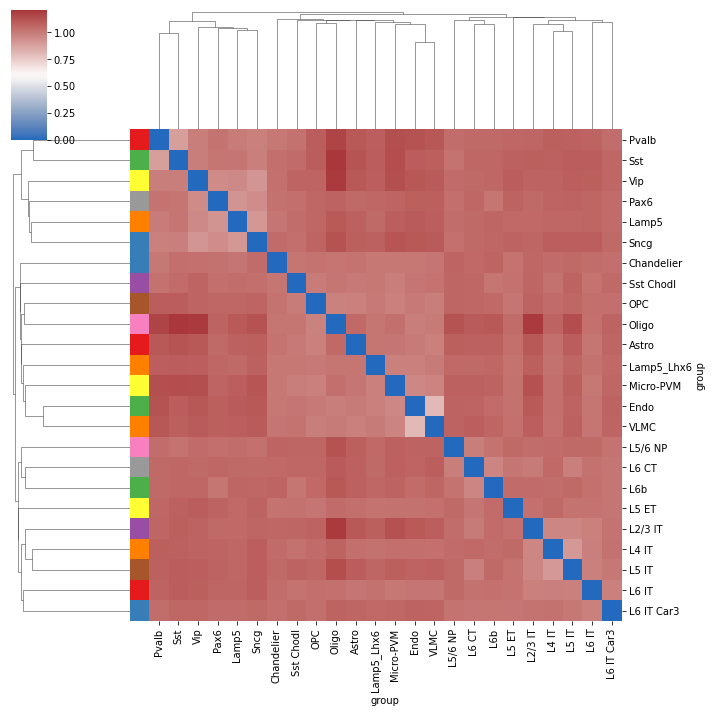

In [37]:
marker_list = marker_list[marker_list['rank'] < 200]

marker_table = marker_list.pivot_table(index='gene', columns='group', values='rank', aggfunc='sum')
marker_table.fillna(0, inplace=True)
marker_table[marker_table != 0] = 1


#dj = pd.concat(df_list)
#dk = pd.concat(df_list_heart)

dk = marker_table.T
#dk = df_list_heart[0]
#dk = dk.groupby(['cell_type', 'group']).mean()
lut = dict(zip( [x.split('_')[0] for x in dk.index.get_level_values('group').tolist()], sns.color_palette("Set1", dk.shape[0])[:]))


row_colors =list(map(lut.get, [x.split('_')[0] for x in dk.index.get_level_values('group').tolist()]))

#lut = dict(zip( dk.index.get_level_values('classt').drop_duplicates(), sns.color_palette("Set1", dk.index.get_level_values('classt').shape[0]).as_hex()[:]))


#row_colors =dk.index.get_level_values('classt').map(lut)



#features = dk.loc[:, pure_bins]
#features = dk.loc[:, bins_intersect]
features = dk.loc[:, :]
features = features.dropna(axis=0)
#features = features.loc[:, dk_max[dk_max>5].index.tolist()]
features_sc =  StandardScaler().fit_transform(features)
R1 = np.round(np.corrcoef(features_sc), 10)
import scipy.spatial as sp, scipy.cluster.hierarchy as hc
df_dist = 1-R1
df_dist[[np.arange(df_dist.shape[0])]*2] = 0
linkage = hc.linkage(sp.distance.squareform(df_dist), method='average')
df_dist_df = pd.DataFrame(df_dist,  index=features.index.get_level_values('group'), columns = features.index.get_level_values('group'))

#sns.clustermap(df_dist_df, row_linkage=linkage, col_linkage=linkage, cmap="vlag", row_colors=row_colors)

sns.clustermap(df_dist_df, row_linkage=linkage, col_linkage=linkage, cmap="vlag", row_colors=row_colors)

In [4]:
import numpy as np
import pandas as pd
from scipy import stats, sparse
import bottleneck
def run_egad(go, nw, **kwargs):
    """EGAD running function
    
    Wrapper to lower level functions for EGAD

    EGAD measures modularity of gene lists in co-expression networks. 

    This was translated from the MATLAB version, which does tiled Cross Validation
    
    The useful kwargs are:
    int - nFold : Number of CV folds to do, default is 3, 
    int - {min,max}_count : limits for number of terms in each gene list, these are exclusive values


    Arguments:
        go {pd.DataFrame} -- dataframe of genes x terms of values [0,1], where 1 is included in gene lists
        nw {pd.DataFrame} -- dataframe of co-expression network, genes x genes
        **kwargs 
    
    Returns:
        pd.DataFrame -- dataframe of terms x metrics where the metrics are 
        ['AUC', 'AVG_NODE_DEGREE', 'DEGREE_NULL_AUC', 'P_Value']
    """
    assert nw.shape[0] == nw.shape[1] , 'Network is not square'
    #print(nw.index)
    #nw.columns = nw.columns.astype(int)
    #print(nw.columns.astype(int))
    assert np.all(nw.index == nw.columns) , 'Network index and columns are not in the same order'

    #nw_mask = nw.isna().sum(axis=1) != nw.shape[1]
    #nw = nw.loc[nw_mask, nw_mask].astype('float')
    #np.fill_diagonal(nw.values, 1)
    return _runNV(go, nw, **kwargs)

def _runNV(go, nw, nFold=3, min_count=1, max_count=1000):

    #Make sure genes are same in go and nw
    #go.index = go.index.map(str) 
    #nw.index = nw.index.map(str)
    #nw.index = nw.index.str.replace('_', '')
    #go.index = go.index.str.replace('_', '')
    #print (nw)
    genes_intersect = go.index.intersection(nw.index)


    #print (genes_intersect)
    go = go.loc[genes_intersect, :]
    nw = nw.loc[genes_intersect, genes_intersect]
    #print (go)
    print (nw.shape)
    print (go.shape)
    sparsity = 1.0 - np.count_nonzero(go) / go.size
    print (sparsity)
    sparsity = 1.0 - np.count_nonzero(nw) / nw.size
    print (sparsity)
    #print(nw
    #print(go
    nw_mask = nw.isna().sum(axis=1) != nw.shape[1]
    nw = nw.loc[nw_mask, nw_mask].astype('float')
    np.fill_diagonal(nw.values, 1)
    #Make sure there aren't duplicates
    duplicates = nw.index.duplicated(keep='first')
    nw = nw.loc[~duplicates, ~duplicates]

    go = go.loc[:, (go.sum(axis=0) > min_count) & (go.sum(axis=0) < max_count)]
    go = go.loc[~go.index.duplicated(keep='first'), :]
    #print(go)

    roc = _new_egad(go.values, nw.values, nFold)

    col_names = ['AUC', 'AVG_NODE_DEGREE', 'DEGREE_NULL_AUC', 'P_Value']
    #Put output in dataframe
    return pd.DataFrame(dict(zip(col_names, roc)), index=go.columns), go

def _new_egad(go, nw, nFold):

    #Build Cross validated Positive
    x, y = np.where(go)
    #print(x, y)
    cvgo = {}
    for i in np.arange(nFold):
        a = x[i::nFold]
        #print(a)
        b = y[i::nFold]
        dat = np.ones_like(a)
        mask = sparse.coo_matrix((dat, (a, b)), shape=go.shape)
        cvgo[i] = go - mask.toarray()

    CVgo = np.concatenate(list(cvgo.values()), axis=1)
    #print(CVgo)

    sumin = np.matmul(nw.T, CVgo)

    degree = np.sum(nw, axis=0)
    #print(degree)
    #print(degree[:, None])

    predicts = sumin / degree[:, None]
    #print(predicts)

    np.place(predicts, CVgo > 0, np.nan)

    #print(predicts)

    #Calculate ranks of positives
    rank_abs = lambda x: stats.rankdata(np.abs(x))
    predicts2 = np.apply_along_axis(rank_abs, 0, predicts)
    #print(predicts2)

    #Masking Nans that were ranked (how tiedrank works in matlab)
    predicts2[np.isnan(predicts)] = np.nan
    #print(predicts2)

    filtering = np.tile(go, nFold)
    #print(filtering)

    #negatives :filtering == 0
    #Sets Ranks of negatives to 0
    np.place(predicts2, filtering == 0, 0)

    #Sum of ranks for each prediction
    p = bottleneck.nansum(predicts2, axis=0)
    n_p = np.sum(filtering, axis=0) - np.sum(CVgo, axis=0)

    #Number of negatives
    #Number of GO terms - number of postiive
    n_n = filtering.shape[0] - np.sum(filtering, axis=0)

    roc = (p / n_p - (n_p + 1) / 2) / n_n
    U = roc * n_p * n_n
    Z = (np.abs(U - (n_p * n_n / 2))) / np.sqrt(n_p * n_n *
                                                (n_p + n_n + 1) / 12)
    roc = roc.reshape(nFold, go.shape[1])
    Z = Z.reshape(nFold, go.shape[1])
    #Stouffer Z method
    Z = bottleneck.nansum(Z, axis=0) / np.sqrt(nFold)
    #Calc ROC of Neighbor Voting
    roc = bottleneck.nanmean(roc, axis=0)
    P = stats.norm.sf(Z)

    #Average degree for nodes in each go term
    avg_degree = degree.dot(go) / np.sum(go, axis=0)

    #Calc null auc for degree
    ranks = np.tile(stats.rankdata(degree), (go.shape[1], 1)).T

    np.place(ranks, go == 0, 0)

    n_p = bottleneck.nansum(go, axis=0)
    nn = go.shape[0] - n_p
    p = bottleneck.nansum(ranks, axis=0)

    roc_null = (p / n_p - ((n_p + 1) / 2)) / nn
    #print(roc)
    return roc, avg_degree, roc_null, P

In [5]:
process_type='inter'

species='human'
SRP_name='aggregates'
resolution='10kbp_raw'

In [6]:
base_folder='/grid/gillis/data_norepl/lohia'

In [7]:
with h5py.File(f'{base_folder}/hi_c_data_processing/data_{species}/{SRP_name}/{resolution}/max/contact_top1/hic_gene_inter_none_by_allbins_top1.h5', 'r') as hf:
    gene_list = hf['gene_list'][:]
    bins_bed = hf['bins_bed'][:]

In [8]:
number_of_genes_list = [10, 50, 100, 150, 200, 250, 500, 1000]
marker_level_list = ['class', 'subclass', 'type']

number_of_genes_list = [1000]
marker_level_list = ['type']

for number_of_genes in number_of_genes_list:
    for marker_level in marker_level_list:


        marker_list = pd.read_csv(f'{base_folder}/hi_c_data_processing/notebooks/metamarkers/human/{marker_level}_markers_top1000.csv.gz', skiprows=1)

        marker_list['gene'] = marker_list['gene'].str.upper()
        df_ensg_name = pd.read_csv(f'{base_folder}/hi_c_data_processing/genomes_jlee/ensg_geneid_symbol.csv', sep='\t')[['Ensembl_gene_identifier', 'Symbol']]
        marker_list = marker_list.merge(df_ensg_name.drop_duplicates(), right_on='Symbol', left_on='gene') 
        #marker_list = marker_list[marker_list['Ensembl_gene_identifier'].isin([x.decode() for x in gene_list])]
        
        all_cell_types = marker_list.drop_duplicates(['cell_type'])['cell_type'].tolist()
        df2_list = []



        for group2 in all_cell_types:
            df2_list.append(marker_list[marker_list['cell_type']==group2].sort_values(by=['rank']).head(number_of_genes))
            #marker_list['cell_type'] =   marker_list['cell_type'].sample(frac = 1).values
            #df2_list.append(marker_list[marker_list['cell_type']==group2].sort_values(by=['rank']).tail(number_of_genes))
            #print ((marker_list[marker_list['cell_type']==group2].sort_values(by=['rank']).head(number_of_genes)).shape[0])
        marker_list=pd.concat(df2_list)
        #marker_list = marker_list[marker_list['rank'] <= number_of_genes] 
        
        #marker_list = marker_list[marker_list['auroc'] >= 0.85] 
        #marker_list = marker_list[marker_list.group.isin(['Sst'])]

        #marker_list = marker_list[marker_list.cell_type.isin(['Pvalb_1', 'Pvalb_2'])]
        #marker_list = marker_list.drop_duplicates(subset=['gene'], keep=False)
                
        #m_number_of_genes = number_of_genes +20
        #marker_list = marker_list[marker_list['rank'] < m_number_of_genes]
        #marker_list = marker_list.sort_values(by=['rank'])
        #print (marker_list)
        marker_list = marker_list.sort_values(by='rank').drop_duplicates(subset=['Ensembl_gene_identifier'])
        
        marker_table = marker_list.pivot_table(index='Ensembl_gene_identifier', columns='cell_type', values='rank', aggfunc='sum')

        marker_table.fillna(0, inplace=True)

        marker_table[marker_table != 0] = 1

In [9]:
cat_list_genes = marker_table.index.tolist()

In [10]:
    input_path=f'{base_folder}/hi_c_data_processing/data_{species}/{SRP_name}/{resolution}/max/'
    bins_bed = pd.read_csv(f'{input_path}/all_bins.bed', names=['chr', 'start', 'end', 'bin_id'])
    bins_bed['bin_id'] = bins_bed.index
    #bins_bed['pos'] = bins_bed['chr'] + '_' + bins_bed['start'].astype('str')
    
    bins_bed.to_csv(f'{input_path}/all_bins_true.bed', index=False, header=False, sep='\t')

    os.system(f"~/.conda/envs/hicexplorer/bin/bedtools intersect -c -b {base_folder}/hi_c_data_processing/data_human/aggregates/li2022/screen_v2/GRCh38-ccREs.bed -a {base_folder}/hi_c_data_processing/data_{species}/{SRP_name}/{resolution}/max/all_bins_true.bed >  {base_folder}/hi_c_data_processing/data_human/{SRP_name}/{resolution}/cre_intersect.bed")
    
    bins_bed_cre = pd.read_csv(f'{base_folder}/hi_c_data_processing/data_human/{SRP_name}/{resolution}/cre_intersect.bed', names=['chr', 'start', 'end', 'bin_id', 'cre'], sep='\t')
    

    
    



    #if species == 'human':

    #        df_cre = pd.read_csv('/grid/gillis/data/lohia/hi_c_data_processing/data_human/aggregates/li2022/GRCh38-cCREs.bed', sep='\t', names=['chr', 'start', 'end', 't1', 't2', 't3'])

    #else:

    #        df_cre = pd.read_csv('/grid/gillis/data/lohia/ATAC_Risa/mm10-cCREs.bed', sep='\t', names=['chr', 'start', 'end', 't1', 't2', 't3'])

    #df_cre['start_bin'] = df_cre['start']/resolution_human
    #df_cre['start_bin'] = df_cre['start_bin'].astype('int')
    #df_cre['start_bin'] = df_cre['start_bin']*resolution_human
    #df_cre['start_bin'] = df_cre['start_bin'].astype('str')
    #df_cre['start_bin'] = df_cre['chr'] + '_' + df_cre['start_bin']
    #df_cre_1kb_encode = df_cre.drop_duplicates(subset=['start_bin'])
    #df_cre['cre'] = 1
    #df_cre = df_cre.groupby(['start_bin'])['cre'].sum().reset_index()
    
    #cre_bins = bins_bed.merge(df_cre, left_on='pos', right_on='start_bin')['bin_id'].tolist()
    

                                                                

      
    chr_list = bins_bed.drop_duplicates(subset=['chr'])['chr'].tolist()
    chrom_index_list = {}
    for chrom in chr_list:
          st = bins_bed[bins_bed['chr'] == chrom]['bin_id'].tolist()[0]
          en = bins_bed[bins_bed['chr'] == chrom]['bin_id'].tolist()[-1]
          chrom_index_list[chrom] = list(range(st, en+1))

    chrom_index_list_intra = {}
    for chrom in chr_list:
        index_list = []
        for chrom2 in chr_list:
            if chrom2 != chrom:
                index_list.extend(chrom_index_list[chrom2])
        
        chrom_index_list_intra[chrom] = index_list

    #exp_file = hm.hiCMatrix(f'{base_folder}/hi_c_data_processing/software/CoCoCoNet/networks/{species}_prioAggNet.h5')
    #exp_genes_all = [x[3].decode() for x in exp_file.cut_intervals]
    #chrom_vals = [x[0] for x in exp_file.cut_intervals]
    
    df_genes_chrom = pd.read_csv(f'{base_folder}/hi_c_data_processing/data_{species}/{SRP_name}/{resolution}/max/all_gene_max.bed', names=['chrom', 'st', 'end', 'gene'])
                
                
    
    
    
    with h5py.File(f'{base_folder}/hi_c_data_processing/data_{species}/{SRP_name}/{resolution}/max/hic_gene_gw_none_by_allbins_none_max.h5', 'r') as hf:
            tot_g = (list(hf.keys()))
    
    if resolution == '1kbp_raw':
        prec = 'float32'
    else:
        prec = 'float32'
    
    
        
    finite_list = []
    gene_list_list = []
    chrn_write_list_list = []
    my_data_thresh_list = []
    gene_depth_list = []
    
    marker_contacts_list_inter = []

    gene_list = []
        
    chrn_write_list = []
    
    for each_chrom in chr_list:
      
        
        if process_type == 'inter':


            with h5py.File(f'{base_folder}/hi_c_data_processing/data_{species}/{SRP_name}/{resolution}/max/hic_gene_gw_none_by_allbins_none_max.h5', 'r') as hf:

                               #for key in all_background_markers:
                               for key, m_chrom in zip(df_genes_chrom['gene'].tolist(), df_genes_chrom['chrom'].tolist()):
                                  #if key in tot_g:
                                    if key in cat_list_genes:
                                    
                                      if m_chrom == each_chrom:
                                            gene_list.append(key)
                                            chrn_write_list.append(m_chrom)

                                            #gene_chrom = gene_bed[gene_bed['gene'] == key]['chr'].values[0]
                                            #which ever chrom the gene falls into, those bins should be nan
                                            my_data = hf[key][()]
                                            my_data = my_data.astype(prec)
                                            my_data[chrom_index_list[each_chrom]] = np.nan
                                            gene_depth_list.append(bottleneck.nansum(my_data))
                                            marker_contacts_list_inter.append(my_data)

        else:

            with h5py.File(f'{base_folder}/hi_c_data_processing/data_{species}/{SRP_name}/{resolution}/max/hic_gene_gw_none_by_allbins_none_max.h5', 'r') as hf:

                               #for key in all_background_markers:
                               for key, m_chrom in zip(df_genes_chrom['gene'].tolist(), df_genes_chrom['chrom'].tolist()):
                                  #if key in tot_g:
                                    if key in cat_list_genes:
                                        if m_chrom == each_chrom:
                                            gene_list.append(key)
                                            chrn_write_list.append(m_chrom)
                                            #which ever chrom the gene falls into, those bins should be nan
                                            my_data = hf[key][()]
                                            my_data = my_data.astype(prec)

                                            #gene_chrom = gene_bed[gene_bed['gene'] == key]['chr'].values[0]
                                            my_data[chrom_index_list_intra[each_chrom]] = np.nan
                                            gene_depth_list.append(bottleneck.nansum(my_data))
                                            marker_contacts_list_inter.append(my_data)
                                        
    my_data = np.array(marker_contacts_list_inter)
                                    

In [11]:
my_data_zcore = stats.zscore(my_data,axis=1, nan_policy='omit')  

In [186]:
my_data_zcore.shape

(13722, 287509)

In [187]:
df_gene_tp_dep = pd.DataFrame(my_data_zcore )


In [204]:
df_gene_tp_dep.head(10).dropna(axis=1).T.max()

0    167.657410
1    172.423218
2    302.967621
3    260.088654
4    426.697723
5    139.794434
6     73.791168
7    214.230133
8    336.118164
9    132.713165
dtype: float32

In [13]:
df_gene_tp = pd.DataFrame(my_data_zcore ,  index=gene_list, columns = bins_bed['bin_id'].tolist())


In [185]:
df_gene_tp

0         1         2         3         4         5       \
ENSG00000104059 -1.212136 -1.212136 -1.212136 -0.308775 -1.212136  0.594587   
ENSG00000171798 -1.230800  0.471255 -0.805286 -0.805286 -0.805286  0.471255   
ENSG00000197085 -1.623398 -0.997050 -1.623398 -0.997050 -0.997050 -0.370702   
ENSG00000010327 -1.149971 -1.149971 -1.149971 -0.727351 -1.149971 -1.149971   
ENSG00000173559 -1.265843 -1.265843 -1.265843 -1.265843 -1.265843  0.341288   
...                   ...       ...       ...       ...       ...       ...   
ENSG00000151892 -1.747624 -0.916024 -1.331824 -1.331824 -1.747624 -0.500225   
ENSG00000161509 -1.166779 -0.398107 -1.166779 -0.782443 -1.166779 -0.013771   
ENSG00000113742 -1.580795 -1.211002 -1.211002 -1.580795 -1.211002 -0.841208   
ENSG00000105419 -0.869353 -0.498270 -0.869353 -0.869353 -0.869353  1.357146   
ENSG00000075399 -0.902742  0.672775 -0.902742 -0.377570  1.197948  5.399327   

                   6         7          8         9       ...    287499  \
ENSG00000104059  0.594587 -0.308775  -0.308775 -0.308775  ... -1.212136   
ENSG00000171798 -0.379772  0.045741   0.471255 -0.805286  ...  0.045741   
ENSG00000197085 -0.683876 -0.370702  -0.057528 -0.683876  ... -1.310224   
ENSG00000010327 -0.304730 -0.727351   0.540510 -0.727351  ... -0.304730   
ENSG00000173559 -1.265843 -0.194422  -0.730133 -0.730133  ... -0.730133   
...                   ...       ...        ...       ...  ...       ...   
ENSG00000151892 -0.500225 -0.916024  -0.916024 -0.916024  ... -1.331824   
ENSG00000161509  0.370566  0.370566  -0.013771 -0.398107  ... -0.782443   
ENSG00000113742 -0.841208 -1.211002  -0.101622 -0.841208  ... -1.580795   
ENSG00000105419  0.614980 -0.127187   0.614980  0.243896  ... -0.498270   
ENSG00000075399  9.075534  5.924500  11.963983  6.187086  ... -0.114983   

                   287500    287501    287502    287503    287504    287505  \
ENSG00000104059 -1.212136 -1.212136 -1.212136 -1.212136 -0.308775 -0.308775   
ENSG00000171798 -1.230800 -0.805286 -1.230800  1.322283  2.598824  1.322283   
ENSG00000197085 -1.310224 -1.310224 -1.623398 -0.997050 -0.370702 -0.997050   
ENSG00000010327 -0.727351 -0.727351 -1.149971 -0.304730  1.385751  0.540510   
ENSG00000173559 -1.265843 -0.730133 -1.265843 -1.265843 -0.730133  0.341288   
...                   ...       ...       ...       ...       ...       ...   
ENSG00000151892 -0.916024 -1.331824 -1.747624 -0.916024 -0.916024 -1.331824   
ENSG00000161509 -1.166779 -1.166779 -1.166779 -0.398107  0.754902  1.139238   
ENSG00000113742 -1.580795 -1.211002 -1.580795 -0.471415 -0.471415 -0.471415   
ENSG00000105419 -0.869353 -0.869353 -0.869353 -0.127187  3.212561  1.357146   
ENSG00000075399 -0.377570 -0.640156 -0.902742  0.147603  4.348982  1.985706   

                   287506    287507    287508  
ENSG00000104059 -0.308775 -1.212136 -1.212136  
ENSG00000171798  2.173310 -0.379772 -1.230800  
ENSG00000197085 -0.683876 -1.310224 -1.623398  
ENSG00000010327 -0.304730 -0.727351 -1.149971  
ENSG00000173559 -0.194422 -1.265843 -1.265843  
...                   ...       ...       ...  
ENSG00000151892 -0.500225 -1.331824 -1.747624  
ENSG00000161509  0.754902 -0.398107 -1.166779  
ENSG00000113742 -0.841208 -0.841208 -1.580795  
ENSG00000105419 -0.498270 -0.869353 -0.869353  
ENSG00000075399  4.086396  0.147603 -0.902742  

[3331 rows x 287509 columns]

In [183]:
df_gene_tp.max(axis=0)

0         -0.004865
1         66.504349
2          6.057615
3         18.731390
4         16.196636
            ...    
287504    21.462933
287505    13.683558
287506    19.200405
287507    44.246758
287508    -0.004865
Length: 287509, dtype: float32

In [245]:
number_of_genes_list = [10, 50, 100, 150, 200, 250, 500, 1000]
marker_level_list = ['class', 'subclass', 'type']

number_of_genes_list = [1000]
marker_level_list = ['type']

for number_of_genes in number_of_genes_list:
    for marker_level in marker_level_list:


        marker_list = pd.read_csv(f'/grid/gillis/data_norepl/lohia/hi_c_data_processing/notebooks/metamarkers/human/{marker_level}_markers_top1000.csv.gz', skiprows=1)

        marker_list['gene'] = marker_list['gene'].str.upper()
        df_ensg_name = pd.read_csv('/grid/gillis/data_norepl//lohia/hi_c_data_processing/genomes_jlee/ensg_geneid_symbol.csv', sep='\t')[['Ensembl_gene_identifier', 'Symbol']]
        marker_list = marker_list.merge(df_ensg_name.drop_duplicates(), right_on='Symbol', left_on='gene') 
        marker_list = marker_list[marker_list['Ensembl_gene_identifier'].isin(gene_list)]
        marker_list['%recurrence'] = marker_list['recurrence'] / marker_list['n_datasets']
        
        #marker_list = marker_list[marker_list['recurrence'] > 0]
        #marker_list['%recurrence'] = 1/marker_list['%recurrence']
        #marker_list = marker_list[marker_list['rank'] < 1000]
        #marker_list = marker_list.sort_values(by='rank').drop_duplicates(subset=['Ensembl_gene_identifier'])
        marker_list = marker_list.sort_values(by=['rank', '%recurrence', 'auroc']).drop_duplicates(subset=['Ensembl_gene_identifier'])
        
        all_cell_types = marker_list.drop_duplicates(['cell_type'])['cell_type'].tolist()
        all_group_types = marker_list.drop_duplicates(['cell_type'])['group'].tolist()
        df2_list = []



        for group2 in all_cell_types:
            #df2_list.append(marker_list[marker_list['cell_type']==group2].sort_values(by=['rank']).head(number_of_genes))
            #df2_list.append(marker_list[marker_list['rank'] < number_of_genes])
            #df2_list.append(marker_list[marker_list['rank'].isin(list(all_marker_1))])
            m_tmp = marker_list[marker_list['cell_type']==group2]
            #df2_list.append(m_tmp[m_tmp['recurrence'] >=0])
            df2_list.append(m_tmp[m_tmp['rank'] < 200])
            #df2_list.append(m_tmp[m_tmp['auroc'] >= 0.7])
            #marker_list['cell_type'] =   marker_list['cell_type'].sample(frac = 1).values
            #df2_list.append(marker_list[marker_list['cell_type']==group2].sort_values(by=['rank']).tail(number_of_genes))
            #print ((marker_list[marker_list['cell_type']==group2].sort_values(by=['rank']).head(number_of_genes)).shape[0])
        marker_list=pd.concat(df2_list)
        #marker_list = marker_list.sort_values(by='rank').drop_duplicates(subset=['Ensembl_gene_identifier'])
        #marker_list = marker_list[marker_list['rank'] <= number_of_genes] 
        
        #marker_list = marker_list[marker_list['auroc'] >= 0.85] 
        #marker_list = marker_list[marker_list.group.isin(['Sst'])]

        #marker_list = marker_list[marker_list.cell_type.isin(['Pvalb_1', 'Pvalb_2'])]
        #marker_list = marker_list.drop_duplicates(subset=['gene'], keep=False)
                
        #m_number_of_genes = number_of_genes +20
        #marker_list = marker_list[marker_list['rank'] < m_number_of_genes]
        #marker_list = marker_list.sort_values(by=['rank'])
        #print (marker_list)
        
        
        marker_table = marker_list.pivot_table(index='Ensembl_gene_identifier', columns='cell_type', values='rank', aggfunc='sum')

        marker_table.fillna(0, inplace=True)

        marker_table[marker_table != 0] = 1

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [259]:
if marker_level == 'type':

    marker_list_t = pd.read_csv('/grid/gillis/data_norepl/lohia/hi_c_data_processing/notebooks/metamarkers/human/subclass_markers_top1000.csv.gz', skiprows=1)

    marker_list_t = marker_list_t.drop_duplicates(subset='cell_type')

    marker_list_t.rename(columns = {'group':'classt'}, inplace = True)
    marker_list_t.rename(columns = {'cell_type':'group'}, inplace = True)


    marker_list = marker_list[['Ensembl_gene_identifier', 'group', 'cell_type']].merge(marker_list_t[['classt', 'group']])
    
if marker_level == 'subclass':
    marker_list.rename(columns = {'group':'classt'}, inplace = True)
    marker_list.rename(columns = {'cell_type':'group'}, inplace = True)
    marker_list['cell_type'] = marker_list['group'].tolist()
    

marker_list = marker_list.sample(frac=1)

marker_list = marker_list[['classt', 'group', 'cell_type', 'Ensembl_gene_identifier']]

df_gene_tp = pd.DataFrame(my_data_zcore ,  index=gene_list, columns = bins_bed['bin_id'].tolist())

df_gene_tp[df_gene_tp > 10] = 10

df_gene_tp = df_gene_tp.loc[marker_list['Ensembl_gene_identifier'].tolist(), :]

df_gene_tp_all_info = df_gene_tp.merge(marker_list, left_on=df_gene_tp.index, right_on=marker_list['Ensembl_gene_identifier'])

df_gene_tp_all_info = df_gene_tp_all_info.set_index('key_0')

df_gene_tp_all_info = df_gene_tp_all_info.drop(columns=['Ensembl_gene_identifier'])

df_gene_tp_all_info_mean = df_gene_tp_all_info.groupby(['classt','group']).mean()

In [ ]:
if marker_level == 'type':

    marker_list_t = pd.read_csv('/grid/gillis/data_norepl/lohia/hi_c_data_processing/notebooks/metamarkers/human/subclass_markers_top1000.csv.gz', skiprows=1)

    marker_list_t = marker_list_t.drop_duplicates(subset='cell_type')

    marker_list_t.rename(columns = {'group':'classt'}, inplace = True)
    marker_list_t.rename(columns = {'cell_type':'group'}, inplace = True)


    marker_list = marker_list[['Ensembl_gene_identifier', 'group', 'cell_type']].merge(marker_list_t[['classt', 'group']])
    
if marker_level == 'subclass':
    marker_list.rename(columns = {'group':'classt'}, inplace = True)
    marker_list.rename(columns = {'cell_type':'group'}, inplace = True)
    marker_list['cell_type'] = marker_list['group'].tolist()
    

marker_list = marker_list.sample(frac=1)

marker_list = marker_list[['classt', 'group', 'cell_type', 'Ensembl_gene_identifier']]

df_gene_tp = pd.DataFrame(my_data_zcore ,  index=gene_list, columns = bins_bed['bin_id'].tolist())

df_gene_tp = df_gene_tp.loc[marker_list['Ensembl_gene_identifier'].tolist(), :]

df_gene_tp_all_info = df_gene_tp.merge(marker_list, left_on=df_gene_tp.index, right_on=marker_list['Ensembl_gene_identifier'])

df_gene_tp_all_info = df_gene_tp_all_info.set_index('key_0')

df_gene_tp_all_info = df_gene_tp_all_info.drop(columns=['Ensembl_gene_identifier'])

df_gene_tp_all_info_mean = df_gene_tp_all_info.groupby(['classt','group']).mean()

In [252]:
df_gene_tp

0         1         2         3         4         5       \
ENSG00000233750       NaN       NaN       NaN       NaN       NaN       NaN   
ENSG00000225972       NaN       NaN       NaN       NaN       NaN       NaN   
ENSG00000225630       NaN       NaN       NaN       NaN       NaN       NaN   
ENSG00000228794       NaN       NaN       NaN       NaN       NaN       NaN   
ENSG00000225880       NaN       NaN       NaN       NaN       NaN       NaN   
...                   ...       ...       ...       ...       ...       ...   
ENSG00000100288 -0.842099  1.484496 -0.609440 -0.376780 -0.376780  2.415134   
ENSG00000008735 -0.769713  1.383385 -0.769713  0.153043  0.153043  2.921312   
ENSG00000100299 -0.555028  0.331139 -0.555028  0.331139 -0.555028  3.285027   
ENSG00000251322 -0.625993  4.515933 -0.625993  0.659488 -0.625993  3.230451   
ENSG00000079974 -0.113090  3.915797 -0.052046  0.070041  0.253173  1.351960   

                   6         7         8         9       ...    287499  \
ENSG00000233750       NaN       NaN       NaN       NaN  ...  0.097758   
ENSG00000225972       NaN       NaN       NaN       NaN  ...  2.077093   
ENSG00000225630       NaN       NaN       NaN       NaN  ... -0.760498   
ENSG00000228794       NaN       NaN       NaN       NaN  ...  0.070811   
ENSG00000225880       NaN       NaN       NaN       NaN  ...  0.044108   
...                   ...       ...       ...       ...  ...       ...   
ENSG00000100288  3.113112  1.251836  2.647793  1.019177  ...       NaN   
ENSG00000008735  4.766824  1.998555  3.844068  1.383385  ...       NaN   
ENSG00000100299  3.285027  1.217305  4.466582  1.512694  ...       NaN   
ENSG00000251322  5.801414  3.230451  4.515933  1.944970  ...       NaN   
ENSG00000079974  0.985698  0.802566  1.779266  0.436304  ...       NaN   

                   287500    287501    287502    287503    287504    287505  \
ENSG00000233750 -0.126252 -0.126252 -0.126252  0.321768  2.561870  1.889840   
ENSG00000225972 -0.333465 -0.333465 -0.333465  0.470054  5.291171  0.470054   
ENSG00000225630 -1.054666 -1.054666 -1.201750  0.710340  3.357849  1.151591   
ENSG00000228794 -0.077792 -0.003490 -0.114942  0.479469  1.259634  0.888127   
ENSG00000225880 -0.147274 -0.019686 -0.147274  0.554459  2.213101  1.575162   
...                   ...       ...       ...       ...       ...       ...   
ENSG00000100288       NaN       NaN       NaN       NaN       NaN       NaN   
ENSG00000008735       NaN       NaN       NaN       NaN       NaN       NaN   
ENSG00000100299       NaN       NaN       NaN       NaN       NaN       NaN   
ENSG00000251322       NaN       NaN       NaN       NaN       NaN       NaN   
ENSG00000079974       NaN       NaN       NaN       NaN       NaN       NaN   

                    287506    287507    287508  
ENSG00000233750   1.665829  0.545778 -0.126252  
ENSG00000225972  10.112288  0.470054 -0.333465  
ENSG00000225630   5.417022 -0.613414 -1.201750  
ENSG00000228794   1.148182  0.107962 -0.114942  
ENSG00000225880   2.021719 -0.019686 -0.147274  
...                    ...       ...       ...  
ENSG00000100288        NaN       NaN       NaN  
ENSG00000008735        NaN       NaN       NaN  
ENSG00000100299        NaN       NaN       NaN  
ENSG00000251322        NaN       NaN       NaN  
ENSG00000079974        NaN       NaN       NaN  

[13722 rows x 287509 columns]

In [230]:
df_gene_tp = pd.DataFrame(my_data_zcore ,  index=gene_list, columns = bins_bed['bin_id'].tolist())


cc = bottleneck.nanmean(df_gene_tp, axis=0)

<Axes: ylabel='Count'>

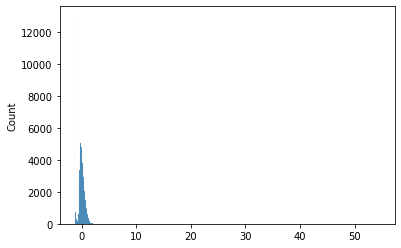

In [244]:
sns.histplot(cc)

In [59]:
df_gene_tp_all_info_mean2 = df_gene_tp_all_info.groupby(['classt','group', 'cell_type']).median().groupby(['classt','group']).median()



In [271]:
df_list  = []
for number_of_times in range(25):
    
    number_of_genes_list = [10, 50, 100, 150, 200, 250, 500, 1000]
    marker_level_list = ['class', 'subclass', 'type']

    number_of_genes_list = [1000]
    marker_level_list = ['type']

    for number_of_genes in number_of_genes_list:
        for marker_level in marker_level_list:


            marker_list = pd.read_csv(f'/grid/gillis/data_norepl/lohia/hi_c_data_processing/notebooks/metamarkers/human/{marker_level}_markers_top1000.csv.gz', skiprows=1)

            marker_list['gene'] = marker_list['gene'].str.upper()
            df_ensg_name = pd.read_csv('/grid/gillis/data_norepl//lohia/hi_c_data_processing/genomes_jlee/ensg_geneid_symbol.csv', sep='\t')[['Ensembl_gene_identifier', 'Symbol']]
            marker_list = marker_list.merge(df_ensg_name.drop_duplicates(), right_on='Symbol', left_on='gene') 
            marker_list = marker_list[marker_list['Ensembl_gene_identifier'].isin(gene_list)]
            marker_list['%recurrence'] = marker_list['recurrence'] / marker_list['n_datasets']

            #marker_list = marker_list[marker_list['recurrence'] > 0]
            #marker_list['%recurrence'] = 1/marker_list['%recurrence']
            #marker_list = marker_list[marker_list['rank'] < 1000]
            #marker_list = marker_list.sort_values(by='rank').drop_duplicates(subset=['Ensembl_gene_identifier'])
            marker_list = marker_list.sort_values(by=['rank', '%recurrence', 'auroc']).drop_duplicates(subset=['Ensembl_gene_identifier'])

            all_cell_types = marker_list.drop_duplicates(['cell_type'])['cell_type'].tolist()
            all_group_types = marker_list.drop_duplicates(['cell_type'])['group'].tolist()
            df2_list = []



            for group2 in all_cell_types:
                #df2_list.append(marker_list[marker_list['cell_type']==group2].sort_values(by=['rank']).head(number_of_genes))
                #df2_list.append(marker_list[marker_list['rank'] < number_of_genes])
                #df2_list.append(marker_list[marker_list['rank'].isin(list(all_marker_1))])
                m_tmp = marker_list[marker_list['cell_type']==group2]
                
                m_tmp = m_tmp[m_tmp['rank'] < 200]
                random_indices = np.random.choice(m_tmp.index, size=len(m_tmp), replace=True)

                # Sample from the original DataFrame using random indices
                bootstrap_sample = m_tmp.loc[random_indices]
                #df2_list.append(m_tmp[m_tmp['recurrence'] >=0])
                df2_list.append(bootstrap_sample)
                #marker_list['cell_type'] =   marker_list['cell_type'].sample(frac = 1).values
                #df2_list.append(marker_list[marker_list['cell_type']==group2].sort_values(by=['rank']).tail(number_of_genes))
                #print ((marker_list[marker_list['cell_type']==group2].sort_values(by=['rank']).head(number_of_genes)).shape[0])
            marker_list=pd.concat(df2_list)
            marker_list = marker_list.sort_values(by='rank').drop_duplicates(subset=['Ensembl_gene_identifier'])
            #marker_list = marker_list[marker_list['rank'] <= number_of_genes] 

            #marker_list = marker_list[marker_list['auroc'] >= 0.85] 
            #marker_list = marker_list[marker_list.group.isin(['Sst'])]

            #marker_list = marker_list[marker_list.cell_type.isin(['Pvalb_1', 'Pvalb_2'])]
            #marker_list = marker_list.drop_duplicates(subset=['gene'], keep=False)

            #m_number_of_genes = number_of_genes +20
            #marker_list = marker_list[marker_list['rank'] < m_number_of_genes]
            #marker_list = marker_list.sort_values(by=['rank'])
            #print (marker_list)


            marker_table = marker_list.pivot_table(index='Ensembl_gene_identifier', columns='cell_type', values='rank', aggfunc='sum')

            marker_table.fillna(0, inplace=True)

            marker_table[marker_table != 0] = 1



    if marker_level == 'type':

        marker_list_t = pd.read_csv('/grid/gillis/data_norepl/lohia/hi_c_data_processing/notebooks/metamarkers/human/subclass_markers_top1000.csv.gz', skiprows=1)

        marker_list_t = marker_list_t.drop_duplicates(subset='cell_type')

        marker_list_t.rename(columns = {'group':'classt'}, inplace = True)
        marker_list_t.rename(columns = {'cell_type':'group'}, inplace = True)


        marker_list = marker_list[['Ensembl_gene_identifier', 'group', 'cell_type']].merge(marker_list_t[['classt', 'group']])

    if marker_level == 'subclass':
        marker_list.rename(columns = {'group':'classt'}, inplace = True)
        marker_list.rename(columns = {'cell_type':'group'}, inplace = True)
        marker_list['cell_type'] = marker_list['group'].tolist()


    marker_list = marker_list.sample(frac=1)

    marker_list = marker_list[['classt', 'group', 'cell_type', 'Ensembl_gene_identifier']]

    df_gene_tp = pd.DataFrame(my_data_zcore ,  index=gene_list, columns = bins_bed['bin_id'].tolist())

    df_gene_tp = df_gene_tp.loc[marker_list['Ensembl_gene_identifier'].tolist(), :]

    df_gene_tp_all_info = df_gene_tp.merge(marker_list, left_on=df_gene_tp.index, right_on=marker_list['Ensembl_gene_identifier'])

    df_gene_tp_all_info = df_gene_tp_all_info.set_index('key_0')

    df_gene_tp_all_info = df_gene_tp_all_info.drop(columns=['Ensembl_gene_identifier'])
    
    df_gene_tp_all_info['boot_id'] = number_of_times

    #df_gene_tp_all_info_mean = df_gene_tp_all_info.groupby(['classt','group']).mean()
    
    #df_list.append(df_gene_tp_all_info_mean)
    
    df_list.append(df_gene_tp_all_info)

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeW

In [109]:
            marker_list = pd.read_csv(f'/grid/gillis/data_norepl/lohia/hi_c_data_processing/notebooks/metamarkers/human/{marker_level}_markers_top1000.csv.gz', skiprows=1)

            marker_list['gene'] = marker_list['gene'].str.upper()
            df_ensg_name = pd.read_csv('/grid/gillis/data_norepl//lohia/hi_c_data_processing/genomes_jlee/ensg_geneid_symbol.csv', sep='\t')[['Ensembl_gene_identifier', 'Symbol']]
            marker_list = marker_list.merge(df_ensg_name.drop_duplicates(), right_on='Symbol', left_on='gene') 
            marker_list = marker_list[marker_list['Ensembl_gene_identifier'].isin(gene_list)]
            marker_list['%recurrence'] = marker_list['recurrence'] / marker_list['n_datasets']

            #marker_list = marker_list[marker_list['recurrence'] > 0]
            #marker_list['%recurrence'] = 1/marker_list['%recurrence']
            #marker_list = marker_list[marker_list['rank'] < 1000]
            #marker_list = marker_list.sort_values(by='rank').drop_duplicates(subset=['Ensembl_gene_identifier'])
            marker_list = marker_list.sort_values(by=['rank', '%recurrence', 'auroc']).drop_duplicates(subset=['Ensembl_gene_identifier'])


/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [113]:
marker_list[marker_list['rank'] < 250].groupby('group')['gene'].count()

group
Astro          331
Chandelier      69
Endo           178
L2/3 IT        373
L4 IT           77
L5 ET          170
L5 IT          243
L5/6 NP        292
L6 CT          169
L6 IT           46
L6 IT Car3     131
L6b            211
Lamp5          134
Lamp5_Lhx6     131
Micro-PVM      350
OPC            124
Oligo         1173
Pax6            81
Pvalb          375
Sncg           221
Sst            585
Sst Chodl       77
VLMC           132
Vip            462
Name: gene, dtype: int64

In [15]:
    input_path=f'{base_folder}/hi_c_data_processing/data_{species}/{SRP_name}/{resolution}/max/'
    bins_bed = pd.read_csv(f'{input_path}/all_bins.bed', names=['chr', 'start', 'end', 'bin_id'])
    bins_bed['bin_id'] = bins_bed.index
    #bins_bed['pos'] = bins_bed['chr'] + '_' + bins_bed['start'].astype('str')
    
    bins_bed.to_csv(f'{input_path}/all_bins_true.bed', index=False, header=False, sep='\t')

In [16]:
pd.read_csv('/grid/gillis/data_norepl/lohia/BICCN_enhancer_challenege/10XMultiome/Human/hg38-blacklist.v2.bed', sep='\t', names=['d', 'd1', 'd2', 'bin_id', 'c', 'c1', 'c2', 'c3', 'c4'])

os.system(f"~/.conda/envs/hicexplorer/bin/bedtools intersect -wo -b /grid/gillis/data_norepl/lohia/BICCN_enhancer_challenege/10XMultiome/Human/hg38-blacklist.v2.bed -a {base_folder}/hi_c_data_processing/data_{species}/{SRP_name}/{resolution}/max/all_bins_true.bed > /grid/gillis/data_norepl/lohia/BICCN_enhancer_challenege/10XMultiome/Human/all_bin_blacklist_10kb.bed")
          
    

0

In [17]:
blacklist_bins = pd.read_csv('/grid/gillis/data_norepl/lohia/BICCN_enhancer_challenege/10XMultiome/Human/all_bin_blacklist_1kb.bed', sep='\t', names=['d', 'd1', 'd2', 'bin_id', 'c', 'c1', 'c2', 'c3', 'c4'])


In [20]:
pure_bins = list(set(df_gene_tp_all_info_mean.columns.tolist()) - set(blacklist_bins['bin_id'].tolist()))


In [21]:
from umap import UMAP
import plotly.express as px
from sklearn.preprocessing import StandardScaler



<ipython-input-164-e5c6d723eabc>:20: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  df_dist[[np.arange(df_dist.shape[0])]*2] = 0


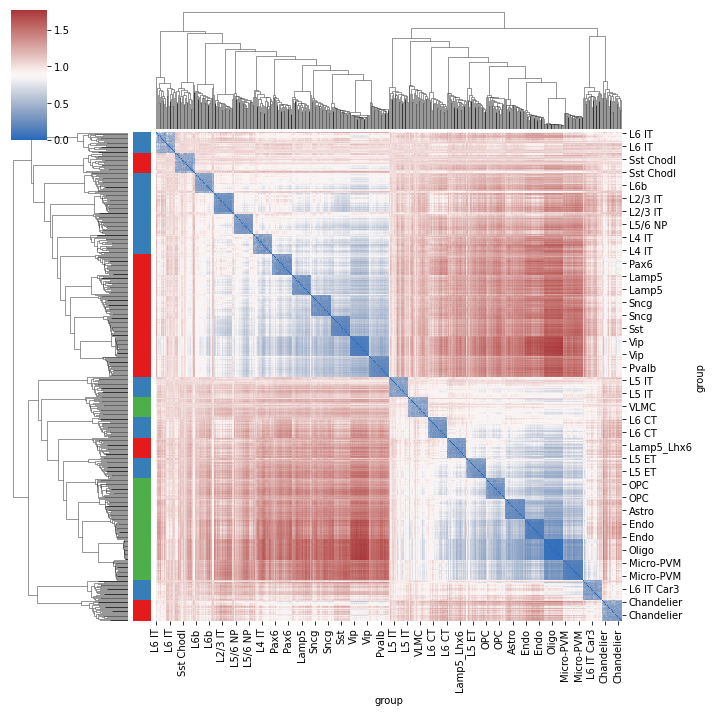

In [164]:
#dj = pd.concat(df_list)
dk = pd.concat(df_list)
#dk = df_gene_tp_all_info_mean
lut = dict(zip( dk.index.get_level_values('classt').drop_duplicates(), sns.color_palette("Set1", dk.index.get_level_values('classt').shape[0]).as_hex()[:]))


row_colors =dk.index.get_level_values('classt').map(lut)



features = dk.loc[:, pure_bins]
#features = dk.loc[:, bins_intersect]
#features = dk.loc[:, :]
features = features.dropna(axis=0)
#features = features.loc[:, dk_max[dk_max>5].index.tolist()]
features_sc =  StandardScaler().fit_transform(features)
R1 = np.round(np.corrcoef(features_sc), 10)
import scipy.spatial as sp, scipy.cluster.hierarchy as hc
df_dist = 1-R1
df_dist[[np.arange(df_dist.shape[0])]*2] = 0
linkage = hc.linkage(sp.distance.squareform(df_dist), method='average')
df_dist_df = pd.DataFrame(df_dist,  index=features.index.get_level_values('group'), columns = features.index.get_level_values('group'))

sns.clustermap(df_dist_df, row_linkage=linkage, col_linkage=linkage, cmap="vlag", row_colors=row_colors)




<ipython-input-260-198fa8b2833c>:24: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  df_dist[[np.arange(df_dist.shape[0])]*2] = 0


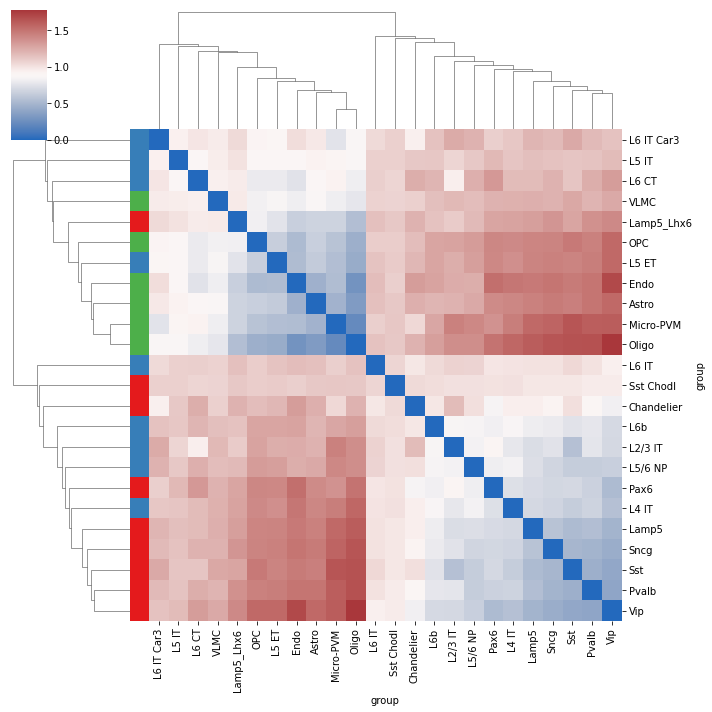

In [260]:
#dj = pd.concat(df_list)
dj = pd.concat(df_list)
dj = dj.reset_index()
#dj = dj[dj['classt']=='GABAergic']
dj['classt'] = ['Non-neuronal' if x =='Other' else x for x in dj['classt']]
dk = dj.groupby(['classt','group']).mean()
#dk = df_gene_tp_all_info_mean
lut = dict(zip( dk.index.get_level_values('classt').drop_duplicates(), sns.color_palette("Set1", dk.index.get_level_values('classt').shape[0]).as_hex()[:]))


row_colors =dk.index.get_level_values('classt').map(lut)



features = dk.loc[:, pure_bins]
#features = dk.loc[:, bins_intersect]
#features = dk.loc[:, :]
features = features.dropna(axis=0)
#features = features.loc[:, dk_max[dk_max>5].index.tolist()]
features_sc =  StandardScaler().fit_transform(features)
R1 = np.round(np.corrcoef(features_sc), 10)
import scipy.spatial as sp, scipy.cluster.hierarchy as hc
df_dist = 1-R1
df_dist[[np.arange(df_dist.shape[0])]*2] = 0
linkage = hc.linkage(sp.distance.squareform(df_dist), method='average')
df_dist_df = pd.DataFrame(df_dist,  index=features.index.get_level_values('group'), columns = features.index.get_level_values('group'))

sns.clustermap(df_dist_df, row_linkage=linkage, col_linkage=linkage, cmap="vlag", row_colors=row_colors)




In [276]:
dj = pd.concat(df_list)

<ipython-input-277-20ad4f1ff02e>:24: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  df_dist[[np.arange(df_dist.shape[0])]*2] = 0


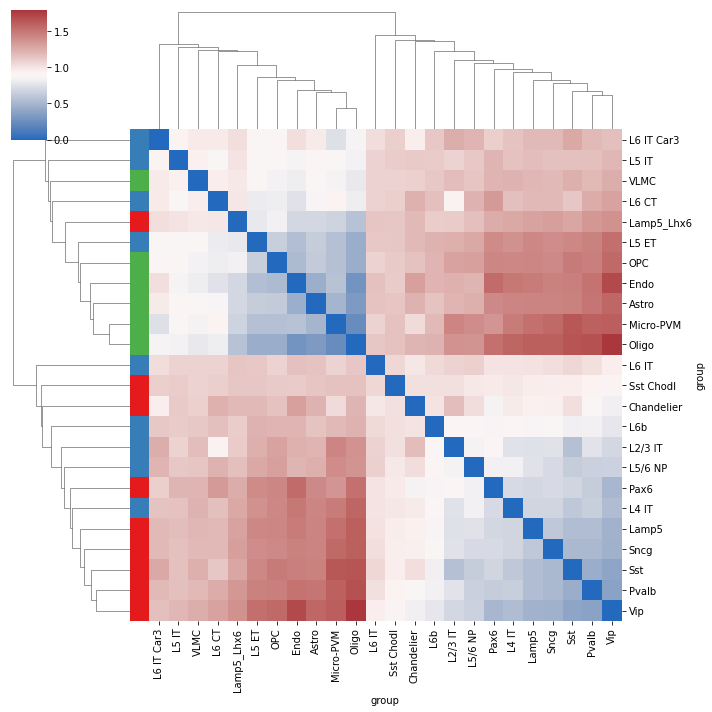

In [277]:
#dj = pd.concat(df_list)
#dj = pd.concat(df_list)
dj = dj.reset_index()
#dj = dj[dj['classt']=='GABAergic']
dj['classt'] = ['Non-neuronal' if x =='Other' else x for x in dj['classt']]
dk = dj.groupby(['classt','group']).mean()
#dk = df_gene_tp_all_info_mean
lut = dict(zip( dk.index.get_level_values('classt').drop_duplicates(), sns.color_palette("Set1", dk.index.get_level_values('classt').shape[0]).as_hex()[:]))


row_colors =dk.index.get_level_values('classt').map(lut)



features = dk.loc[:, pure_bins]
#features = dk.loc[:, bins_intersect]
#features = dk.loc[:, :]
features = features.dropna(axis=0)
#features = features.loc[:, dk_max[dk_max>5].index.tolist()]
features_sc =  StandardScaler().fit_transform(features)
R1 = np.round(np.corrcoef(features_sc), 10)
import scipy.spatial as sp, scipy.cluster.hierarchy as hc
df_dist = 1-R1
df_dist[[np.arange(df_dist.shape[0])]*2] = 0
linkage = hc.linkage(sp.distance.squareform(df_dist), method='average')
df_dist_df = pd.DataFrame(df_dist,  index=features.index.get_level_values('group'), columns = features.index.get_level_values('group'))

sns.clustermap(df_dist_df, row_linkage=linkage, col_linkage=linkage, cmap="vlag", row_colors=row_colors)




<ipython-input-361-786663c61b6b>:26: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  df_dist[[np.arange(df_dist.shape[0])]*2] = 0


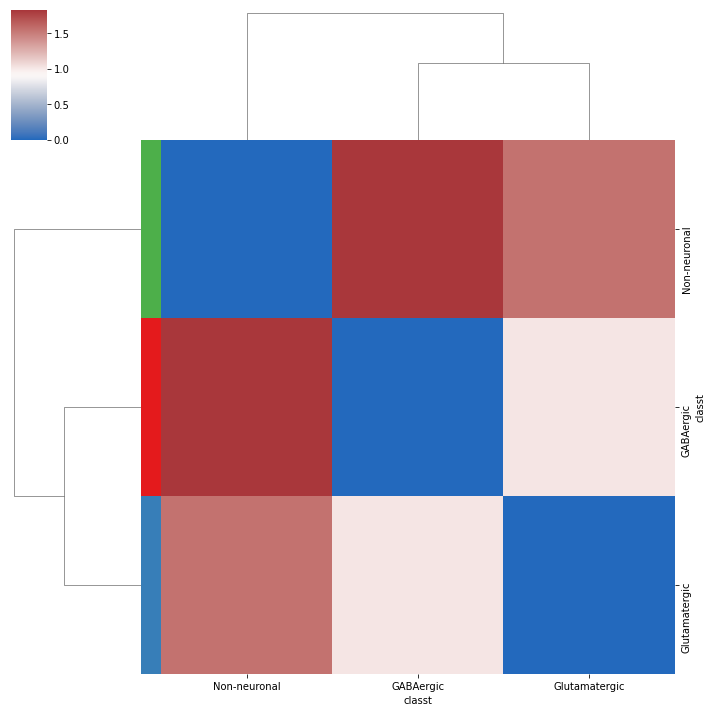

In [361]:
#dj = pd.concat(df_list)
#dj = pd.concat(df_list)

dj = df_gene_tp_all_info_mean
dj = dj.reset_index()
#dj = dj[dj['classt']=='GABAergic']
dj['classt'] = ['Non-neuronal' if x =='Other' else x for x in dj['classt']]
dk = dj.groupby(['classt']).mean()
#dk = df_gene_tp_all_info_mean
lut = dict(zip( dk.index.get_level_values('classt').drop_duplicates(), sns.color_palette("Set1", dk.index.get_level_values('classt').shape[0]).as_hex()[:]))


row_colors =dk.index.get_level_values('classt').map(lut)



features = dk.loc[:, pure_bins]
#features = dk.loc[:, bins_intersect]
#features = dk.loc[:, :]
features = features.dropna(axis=0)
#features = features.loc[:, dk_max[dk_max>5].index.tolist()]
features_sc =  StandardScaler().fit_transform(features)
R1 = np.round(np.corrcoef(features_sc), 10)
import scipy.spatial as sp, scipy.cluster.hierarchy as hc
df_dist = 1-R1
df_dist[[np.arange(df_dist.shape[0])]*2] = 0
linkage = hc.linkage(sp.distance.squareform(df_dist), method='average')
df_dist_df = pd.DataFrame(df_dist,  index=features.index.get_level_values('classt'), columns = features.index.get_level_values('classt'))

sns.clustermap(df_dist_df, row_linkage=linkage, col_linkage=linkage, cmap="vlag", row_colors=row_colors)




In [369]:
df_dist_df = pd.DataFrame(features,  index=features.index.get_level_values('classt'))


/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<Axes: xlabel='Non-neuronal'>

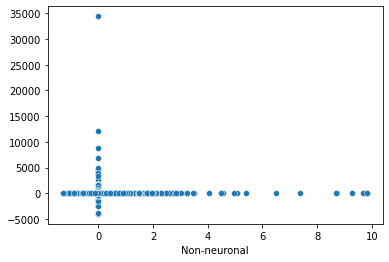

In [374]:
sns.scatterplot(df_dist_df.T['Non-neuronal'], df_dist_df.T['GABAergic']/df_dist_df.T['Non-neuronal'])

In [373]:
df_dist_df.T['GABAergic']/df_dist_df.T['Non-neuronal']

793        0.766961
794        0.763731
795        0.603388
796       -2.155111
797        0.773189
            ...    
287504     0.365662
287505    11.148870
287506     2.705260
287507     1.108730
287508     1.079041
Length: 264607, dtype: float32

In [366]:
df_dist_df.T['GABAergic'].median()

0.629462718963623

In [367]:
df_dist_df.T['Non-neuronal'].median()

-0.9559821486473083

In [272]:
df_list

[                        0         1         2         3         4         5  \
 key_0                                                                         
 ENSG00000068903 -0.112394 -0.112394 -0.112394 -0.112394 -0.112394 -0.112394   
 ENSG00000113597 -1.395478 -0.946868 -1.395478 -0.946868 -1.395478 -0.946868   
 ENSG00000188846 -0.446720 -0.267694 -0.446720 -0.267694 -0.446720  0.448412   
 ENSG00000231538 -0.943775  1.691698 -0.943775 -0.943775 -0.065284 -0.943775   
 ENSG00000138031 -1.348430 -1.002835 -1.348430 -1.002835 -1.002835 -0.311645   
 ...                   ...       ...       ...       ...       ...       ...   
 ENSG00000138071 -0.613001 -0.444212 -0.613001 -0.613001 -0.613001 -0.275423   
 ENSG00000185386 -0.750635  0.306779 -0.750635 -0.750635 -0.398164  0.306779   
 ENSG00000196208 -1.583463 -1.192802 -0.802141 -1.192802 -1.192802  0.369842   
 ENSG00000123143 -1.166926 -0.063595 -1.166926 -1.166926 -0.799149  2.143066   
 ENSG00000132437 -1.700490 -0.803851 -1.

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


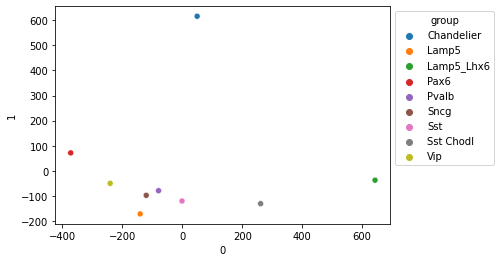

In [161]:
from umap import UMAP
import plotly.express as px
from sklearn.preprocessing import StandardScaler



#umap_2d = UMAP(n_components=2, init='random', random_state=1)


#proj_2d = umap_2d.fit_transform(1-R1)

from sklearn.decomposition import PCA
pca = PCA(n_components=3, random_state=1)
proj_2d = pca.fit_transform(features_sc)


df_proj_2d= pd.DataFrame(proj_2d)


df_proj_2d['group'] = features.index.get_level_values('group')
#df_proj_2d = df_proj_2d[df_proj_2d['classt'] = 'Glutamatergic']
#df_proj_2d['classt'] = [class_dict[x] if x in class_dict.keys() else 'miss' for x in df_proj_2d['group']]
ax=sns.scatterplot(
    df_proj_2d[0],df_proj_2d[1],
    hue=df_proj_2d['group'],
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))


In [139]:
dk.reset_index()[dk.reset_index()['classt'] == 'Glutamatergic']['group'].tolist()

['L2/3 IT',
 'L4 IT',
 'L5 ET',
 'L5 IT',
 'L5/6 NP',
 'L6 CT',
 'L6 IT',
 'L6 IT Car3',
 'L6b',
 'L2/3 IT',
 'L4 IT',
 'L5 ET',
 'L5 IT',
 'L5/6 NP',
 'L6 CT',
 'L6 IT',
 'L6 IT Car3',
 'L6b',
 'L2/3 IT',
 'L4 IT',
 'L5 ET',
 'L5 IT',
 'L5/6 NP',
 'L6 CT',
 'L6 IT',
 'L6 IT Car3',
 'L6b',
 'L2/3 IT',
 'L4 IT',
 'L5 ET',
 'L5 IT',
 'L5/6 NP',
 'L6 CT',
 'L6 IT',
 'L6 IT Car3',
 'L6b',
 'L2/3 IT',
 'L4 IT',
 'L5 ET',
 'L5 IT',
 'L5/6 NP',
 'L6 CT',
 'L6 IT',
 'L6 IT Car3',
 'L6b',
 'L2/3 IT',
 'L4 IT',
 'L5 ET',
 'L5 IT',
 'L5/6 NP',
 'L6 CT',
 'L6 IT',
 'L6 IT Car3',
 'L6b',
 'L2/3 IT',
 'L4 IT',
 'L5 ET',
 'L5 IT',
 'L5/6 NP',
 'L6 CT',
 'L6 IT',
 'L6 IT Car3',
 'L6b',
 'L2/3 IT',
 'L4 IT',
 'L5 ET',
 'L5 IT',
 'L5/6 NP',
 'L6 CT',
 'L6 IT',
 'L6 IT Car3',
 'L6b',
 'L2/3 IT',
 'L4 IT',
 'L5 ET',
 'L5 IT',
 'L5/6 NP',
 'L6 CT',
 'L6 IT',
 'L6 IT Car3',
 'L6b',
 'L2/3 IT',
 'L4 IT',
 'L5 ET',
 'L5 IT',
 'L5/6 NP',
 'L6 CT',
 'L6 IT',
 'L6 IT Car3',
 'L6b',
 'L2/3 IT',
 'L4 IT',
 'L5 ET'

In [375]:
dk = pd.concat(df_list)

In [309]:
dk['type_index'] = [x.split('_')[-1] for x in dk['cell_type'] ]

dk['2_groups'] = [1 if int(x) % 2 == 1 else 2 for x in dk['type_index'] ]

In [316]:
dk

0         1         2       \
classt       group      2_groups boot_id                                 
GABAergic    Chandelier 1        0       -1.494214 -0.811570 -1.255948   
                                 1       -1.469405 -0.589271 -1.294061   
                                 2       -1.482747 -0.760454 -1.294334   
                                 3       -1.513798 -0.674623 -1.289935   
                                 4       -1.498954 -0.546882 -1.317932   
...                                            ...       ...       ...   
Non-neuronal VLMC       2        20      -1.281276 -0.789888 -1.223135   
                                 21      -1.181150 -0.745750 -1.075876   
                                 22      -1.304555 -0.853787 -1.215001   
                                 23      -1.241085 -0.802395 -1.166845   
                                 24      -1.257589 -0.748705 -1.152229   

                                            3         4         5       \
classt       group      2_groups boot_id                                 
GABAergic    Chandelier 1        0       -1.081026 -0.971808  0.254561   
                                 1       -1.042616 -0.994716  0.034638   
                                 2       -0.975077 -1.035970 -0.271971   
                                 3       -0.984586 -0.995519  0.151704   
                                 4       -0.990306 -0.921364  0.209276   
...                                            ...       ...       ...   
Non-neuronal VLMC       2        20      -0.987308 -1.033596 -0.523932   
                                 21      -0.912617 -0.876930 -0.344143   
                                 22      -1.011986 -0.974594 -0.400870   
                                 23      -1.017925 -0.980192 -0.464846   
                                 24      -0.951053 -0.964564 -0.474653   

                                            6         7         8       \
classt       group      2_groups boot_id                                 
GABAergic    Chandelier 1        0        0.045536 -0.423779  0.295802   
                                 1       -0.076770 -0.479298  0.171485   
                                 2       -0.481866 -0.781442 -0.318696   
                                 3        0.044047 -0.497629  0.290069   
                                 4        0.216530 -0.333263  0.456427   
...                                            ...       ...       ...   
Non-neuronal VLMC       2        20      -0.596263 -0.687891 -0.327900   
                                 21      -0.371866 -0.506990 -0.118150   
                                 22      -0.492287 -0.609271 -0.153091   
                                 23      -0.537213 -0.617320 -0.270875   
                                 24      -0.524755 -0.599316 -0.193476   

                                            9       ...    287499    287500  \
classt       group      2_groups boot_id            ...                       
GABAergic    Chandelier 1        0       -0.467485  ... -1.035767 -1.303156   
                                 1       -0.564526  ... -1.008717 -1.283601   
                                 2       -0.739421  ... -1.068895 -1.268763   
                                 3       -0.522504  ... -0.995750 -1.315491   
                                 4       -0.367722  ... -0.960654 -1.282525   
...                                            ...  ...       ...       ...   
Non-neuronal VLMC       2        20      -0.777170  ... -0.863760 -1.211208   
                                 21      -0.617386  ... -0.850112 -1.105028   
                                 22      -0.663943  ... -0.875839 -1.186996   
                                 23      -0.699874  ... -0.894036 -1.178328   
                                 24      -0.697888  ... -0.848993 -1.132677   

                                            287501    287502    287503  \
classt       group      2_groups boot_id             

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


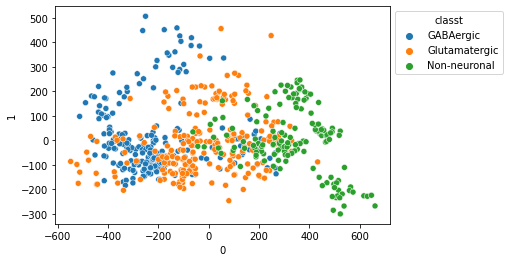

In [376]:
from umap import UMAP
import plotly.express as px
from sklearn.preprocessing import StandardScaler



#umap_2d = UMAP(n_components=2, init='random', random_state=1)


#proj_2d = umap_2d.fit_transform(1-R1)

#dj = pd.concat(df_list)
#dk = pd.concat(df_list)
dk = dk.groupby(['classt','group', 'boot_id']).mean()
#dk = dk.groupby(['classt','group', '2_groups', 'boot_id']).mean()
#dk = df_gene_tp_all_info_mean
lut = dict(zip( dk.index.get_level_values('classt').drop_duplicates(), sns.color_palette("Set1", dk.index.get_level_values('classt').shape[0]).as_hex()[:]))


row_colors =dk.index.get_level_values('classt').map(lut)



features = dk.loc[:, pure_bins]
#features = dk.loc[:, bins_intersect]
#features = dk.loc[:, :]
features = features.dropna(axis=0)
#features = features.loc[:, dk_max[dk_max>5].index.tolist()]
features_sc =  StandardScaler().fit_transform(features)

from sklearn.decomposition import PCA
pca = PCA(n_components=3, random_state=1)
proj_2d = pca.fit_transform(features_sc)


df_proj_2d= pd.DataFrame(proj_2d)


df_proj_2d['classt'] = features.index.get_level_values('classt')
#df_proj_2d = df_proj_2d[df_proj_2d['classt'] = 'Glutamatergic']
#df_proj_2d['classt'] = [class_dict[x] if x in class_dict.keys() else 'miss' for x in df_proj_2d['group']]
ax=sns.scatterplot(
    df_proj_2d[0],df_proj_2d[1],
    hue=df_proj_2d['classt'],
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))


In [296]:
cell_type_division = df_list[0].groupby(['group', 'cell_type'])['boot_id'].count().reset_index()
cell_type_division['type_index'] = [x.split('_')[-1] for x in cell_type_division['cell_type'] ]

cell_type_division['2_groups'] = [1 if int(x) % 2 == 1 else 2 for x in cell_type_division['type_index'] ]

In [302]:
cell_type_division

group cell_type  boot_id type_index  2_groups
0    Astro   Astro_1       58          1         1
1    Astro   Astro_2       32          2         2
2    Astro   Astro_3       27          3         1
3    Astro   Astro_4       22          4         2
4    Astro   Astro_5       41          5         1
..     ...       ...      ...        ...       ...
165    Vip     Vip_5        9          5         1
166    Vip     Vip_6        5          6         2
167    Vip     Vip_7       11          7         1
168    Vip     Vip_8       15          8         2
169    Vip     Vip_9        9          9         1

[170 rows x 5 columns]

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


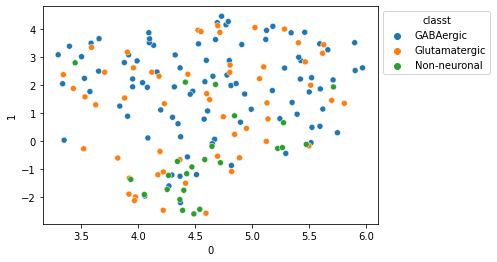

In [279]:
umap_2d = UMAP(n_components=2, init='random', random_state=1)


proj_2d = umap_2d.fit_transform(features_sc)


df_proj_2d= pd.DataFrame(proj_2d)


df_proj_2d['classt'] = features.index.get_level_values('classt')
#df_proj_2d = df_proj_2d[df_proj_2d['classt'] = 'Glutamatergic']
#df_proj_2d['classt'] = [class_dict[x] if x in class_dict.keys() else 'miss' for x in df_proj_2d['group']]
ax=sns.scatterplot(
    df_proj_2d[0],df_proj_2d[1],
    hue=df_proj_2d['classt'],
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


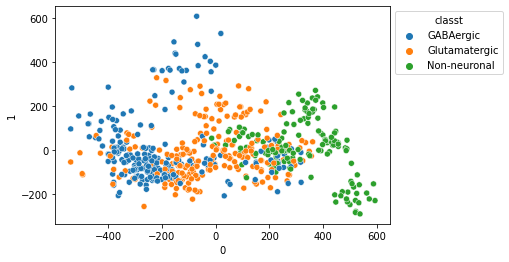

In [263]:
from umap import UMAP
import plotly.express as px
from sklearn.preprocessing import StandardScaler



#umap_2d = UMAP(n_components=2, init='random', random_state=1)


#proj_2d = umap_2d.fit_transform(1-R1)

#dj = pd.concat(df_list)
dk = pd.concat(df_list)
#dk = df_gene_tp_all_info_mean
lut = dict(zip( dk.index.get_level_values('classt').drop_duplicates(), sns.color_palette("Set1", dk.index.get_level_values('classt').shape[0]).as_hex()[:]))


row_colors =dk.index.get_level_values('classt').map(lut)



features = dk.loc[:, pure_bins]
#features = dk.loc[:, bins_intersect]
#features = dk.loc[:, :]
features = features.dropna(axis=0)
#features = features.loc[:, dk_max[dk_max>5].index.tolist()]
features_sc =  StandardScaler().fit_transform(features)

from sklearn.decomposition import PCA
pca = PCA(n_components=3, random_state=1)
proj_2d = pca.fit_transform(features_sc)


df_proj_2d= pd.DataFrame(proj_2d)


df_proj_2d['classt'] = features.index.get_level_values('classt')
#df_proj_2d = df_proj_2d[df_proj_2d['classt'] = 'Glutamatergic']
#df_proj_2d['classt'] = [class_dict[x] if x in class_dict.keys() else 'miss' for x in df_proj_2d['group']]
ax=sns.scatterplot(
    df_proj_2d[0],df_proj_2d[1],
    hue=df_proj_2d['classt'],
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))


/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


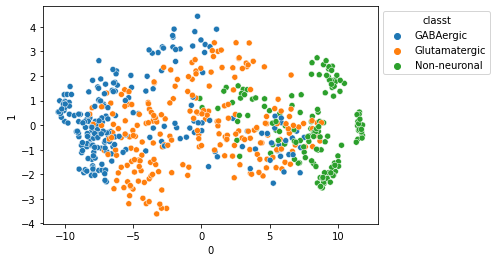

In [167]:
from umap import UMAP
import plotly.express as px
from sklearn.preprocessing import StandardScaler



#umap_2d = UMAP(n_components=2, init='random', random_state=1)


#proj_2d = umap_2d.fit_transform(1-R1)

from sklearn.decomposition import PCA
pca = PCA(n_components=3, random_state=1)
proj_2d = pca.fit_transform(1-R1)


df_proj_2d= pd.DataFrame(proj_2d)


df_proj_2d['classt'] = features.index.get_level_values('classt')
#df_proj_2d = df_proj_2d[df_proj_2d['classt'] = 'Glutamatergic']
#df_proj_2d['classt'] = [class_dict[x] if x in class_dict.keys() else 'miss' for x in df_proj_2d['group']]
ax=sns.scatterplot(
    df_proj_2d[0],df_proj_2d[1],
    hue=df_proj_2d['classt'],
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))


/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


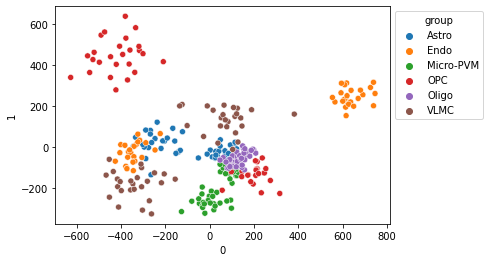

In [315]:

#dk = pd.concat(df_list)
#dk = df_gene_tp_all_info_mean
lut = dict(zip( dk.index.get_level_values('classt').drop_duplicates(), sns.color_palette("Set1", dk.index.get_level_values('classt').shape[0]).as_hex()[:]))


row_colors =dk.index.get_level_values('classt').map(lut)



features = dk.loc[:, pure_bins]
#features = dk.loc[:, bins_intersect]
#features = dk.loc[:, :]
features = features.dropna(axis=0)
#features = features.loc[:, dk_max[dk_max>5].index.tolist()]

features = features[features.index.get_level_values('classt') == 'Non-neuronal']
features_sc =  StandardScaler().fit_transform(features)

from sklearn.decomposition import PCA
pca = PCA(n_components=3, random_state=1)
proj_2d = pca.fit_transform(features_sc)

umap_2d = UMAP(n_components=2, init='random', random_state=1)


#proj_2d = umap_2d.fit_transform(features_sc)

df_proj_2d= pd.DataFrame(proj_2d)


df_proj_2d['classt'] = features.index.get_level_values('classt')
df_proj_2d['group'] = features.index.get_level_values('group')
#df_proj_2d = df_proj_2d[df_proj_2d['classt'] == 'Glutamatergic']
#df_proj_2d['classt'] = [class_dict[x] if x in class_dict.keys() else 'miss' for x in df_proj_2d['group']]
ax=sns.scatterplot(
    df_proj_2d[0],df_proj_2d[1],
    hue=df_proj_2d['group'],
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))


In [313]:
df_list[0]

0         1         2         3         4         5  \
key_0                                                                         
ENSG00000068903 -0.112394 -0.112394 -0.112394 -0.112394 -0.112394 -0.112394   
ENSG00000113597 -1.395478 -0.946868 -1.395478 -0.946868 -1.395478 -0.946868   
ENSG00000188846 -0.446720 -0.267694 -0.446720 -0.267694 -0.446720  0.448412   
ENSG00000231538 -0.943775  1.691698 -0.943775 -0.943775 -0.065284 -0.943775   
ENSG00000138031 -1.348430 -1.002835 -1.348430 -1.002835 -1.002835 -0.311645   
...                   ...       ...       ...       ...       ...       ...   
ENSG00000138071 -0.613001 -0.444212 -0.613001 -0.613001 -0.613001 -0.275423   
ENSG00000185386 -0.750635  0.306779 -0.750635 -0.750635 -0.398164  0.306779   
ENSG00000196208 -1.583463 -1.192802 -0.802141 -1.192802 -1.192802  0.369842   
ENSG00000123143 -1.166926 -0.063595 -1.166926 -1.166926 -0.799149  2.143066   
ENSG00000132437 -1.700490 -0.803851 -1.700490 -1.700490 -0.803851 -0.355532   

                        6         7         8         9  ...    287503  \
key_0                                                    ...             
ENSG00000068903 -0.112394 -0.112394 -0.112394 -0.112394  ... -0.112394   
ENSG00000113597 -0.498258 -0.946868 -0.049648 -0.946868  ... -0.946868   
ENSG00000188846 -0.446720 -0.446720 -0.446720 -0.088667  ... -0.446720   
ENSG00000231538 -0.943775 -0.943775 -0.943775 -0.943775  ... -0.065284   
ENSG00000138031 -0.311645 -0.657240 -0.311645 -1.002835  ... -1.002835   
...                   ...       ...       ...       ...  ...       ...   
ENSG00000138071 -0.275423 -0.444212 -0.106634 -0.444212  ... -0.275423   
ENSG00000185386  0.306779 -0.045692  2.069137  0.306779  ...       NaN   
ENSG00000196208 -0.802141 -0.411480 -1.192802 -0.411480  ... -0.802141   
ENSG00000123143  1.039735  1.775289  1.407512  0.671958  ... -0.431372   
ENSG00000132437 -0.803851 -0.355532 -0.355532 -0.355532  ... -0.355532   

                   287504    287505    287506    287507    287508  \
key_0                                                               
ENSG00000068903 -0.112394 -0.112394 -0.112394 -0.112394 -0.112394   
ENSG00000113597  0.398961 -0.498258 -0.498258 -1.395478 -1.395478   
ENSG00000188846 -0.088667 -0.088667 -0.446720 -0.267694 -0.446720   
ENSG00000231538  4.327171  1.691698  1.691698 -0.943775 -0.943775   
ENSG00000138031  0.379546  0.033951 -0.657240 -1.002835 -1.348430   
...                   ...       ...       ...       ...       ...   
ENSG00000138071 -0.106634 -0.106634 -0.613001 -0.444212 -0.613001   
ENSG00000185386       NaN       NaN       NaN       NaN       NaN   
ENSG00000196208 -0.411480 -0.411480 -1.192802 -1.192802 -1.583463   
ENSG00000123143  1.039735  1.407512 -0.063595 -1.166926 -1.166926   
ENSG00000132437  0.541107 -0.803851 -0.355532 -1.252171 -1.700490   

                        classt      group    cell_type  boot_id  
key_0                                                            
ENSG00000068903   Non-neuronal        OPC        OPC_1        0  
ENSG00000113597   Non-neuronal      Oligo      Oligo_7        0  
ENSG00000188846      GABAergic        Sst       Sst_18        0  
ENSG00000231538   Non-neuronal      Astro      Astro_1        0  
ENSG00000138031      GABAergic        Vip       Vip_15        0  
...                        ...        ...          ...      ...  
ENSG00000138071  Glutamatergic    L2/3 IT   L2/3 IT_10        0  
ENSG00000185386  Glutamatergic      L5 IT      L5 IT_5        0  
ENSG00000196208      GABAergic        Vip       Vip_10        0  
ENSG00000123143      GABAergic  Sst Chodl  Sst Chodl_1        0  
ENSG00000132437      GABAergic  Sst Chodl  Sst Chodl_1        0  

[3330 rows x 287513 columns]

In [266]:
features[features.index.get_level_values('classt') == 'GABAergic']

793       794       795       796       797     \
classt    group                                                          
GABAergic Chandelier  0.495444  0.516357  0.096440  0.087150  0.599601   
          Lamp5       0.363749  0.720976  0.109401 -0.194423  0.603928   
          Lamp5_Lhx6  0.905038  0.895206  0.472935 -0.024145  0.717577   
          Pax6        0.474847  0.710719  0.051476 -0.146006  0.506244   
          Pvalb       0.652398  0.621498  0.229712 -0.097444  0.608472   
...                        ...       ...       ...       ...       ...   
          Pvalb       0.621424  0.585043  0.166111 -0.081271  0.584235   
          Sncg        0.643587  0.703861  0.475658 -0.143440  0.631221   
          Sst         0.649573  0.745306  0.204640 -0.080510  0.712164   
          Sst Chodl   0.626151  0.699083  0.332628 -0.191984  0.574507   
          Vip         0.556466  0.734434  0.156233 -0.117752  0.576490   

                        798       799       800       801       802     ...  \
classt    group                                                         ...   
GABAergic Chandelier  0.241758  0.371782  1.151441  0.828590 -0.005677  ...   
          Lamp5       0.337334  0.276577  0.459124  0.862201  0.020742  ...   
          Lamp5_Lhx6  0.238986  0.479155  0.617170  0.837423  0.138885  ...   
          Pax6        0.177315  0.505915  0.521363  0.802565  0.018119  ...   
          Pvalb       0.223410  0.457833  0.428914  0.741030  0.050721  ...   
...                        ...       ...       ...       ...       ...  ...   
          Pvalb       0.207197  0.385398  0.362090  0.726300  0.037745  ...   
          Sncg        0.073241  0.493582  0.381759  0.771365  0.035667  ...   
          Sst         0.217262  0.370425  0.472406  0.700625  0.014832  ...   
          Sst Chodl   0.130174  0.405748  0.267730  0.944561 -0.008601  ...   
          Vip         0.142612  0.339782  0.417044  0.665093  0.120681  ...   

                        287499    287500    287501    287502    287503  \
classt    group                                                          
GABAergic Chandelier -1.091821 -1.297956 -0.890958 -1.412922 -0.820811   
          Lamp5      -1.069776 -1.258868 -1.191702 -1.407214 -0.741027   
          Lamp5_Lhx6 -0.931557 -1.169865 -1.126529 -1.264626 -0.616782   
          Pax6       -1.055529 -1.298632 -1.170932 -1.408251 -0.641272   
          Pvalb      -1.039834 -1.223430 -1.134730 -1.370854 -0.640240   
...                        ...       ...       ...       ...       ...   
          Pvalb      -1.011007 -1.237861 -1.094517 -1.360389 -0.624705   
          Sncg       -1.062469 -1.217789 -1.176409 -1.389299 -0.704605   
          Sst        -1.020989 -1.207625 -1.130582 -1.288125 -0.607480   
          Sst Chodl  -1.008048 -1.254874 -1.133755 -1.353685 -0.684028   
          Vip        -1.095609 -1.279680 -1.207807 -1.399115 -0.717139   

                        287504    287505    287506    287507    287508  
classt    group                                                         
GABAergic Chandelier -0.043169 -0.416802 -0.419258 -1.026658 -1.452875  
          Lamp5       0.034639 -0.160859 -0.403535 -1.003666 -1.418105  
          Lamp5_Lhx6  0.416139 -0.082892 -0.205509 -0.939204 -1.279613  
          Pax6        0.262456 -0.357975 -0.229519 -0.988465 -1.425800  
          Pvalb       0.102707 -0.290087 -0.285476 -0.982215 -1.397838  
...                        ...       ...       ...       ...       ...  
          Pvalb       0.178503 -0.201879 -0.254793 -0.705820 -1.382301  
          Sncg       -0.017557 -0.347093 -0.376936 -1.009115 -1.407921  
          Sst         0.245971 -0.218770 -0.176244 -0.863929 -1.346663  
          Sst Chodl   0.395576 -0.014763 -0.253259 -0.944415 -1.353685  
          Vip        -0.031567 -0.378851 -0.429875 -0.999598 -1.412491  

[225 rows x 264607 columns]

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


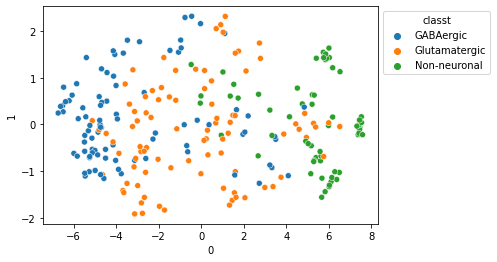

In [132]:
from umap import UMAP
import plotly.express as px
from sklearn.preprocessing import StandardScaler



#umap_2d = UMAP(n_components=2, init='random', random_state=1)


#proj_2d = umap_2d.fit_transform(1-R1)

from sklearn.decomposition import PCA
pca = PCA(n_components=3, random_state=1)
proj_2d = pca.fit_transform(1-R1)


df_proj_2d= pd.DataFrame(proj_2d)


df_proj_2d['classt'] = features.index.get_level_values('classt')
df_proj_2d['classt'] = features.index.get_level_values('classt')
#df_proj_2d = df_proj_2d[df_proj_2d['classt'] = 'Glutamatergic']
#df_proj_2d['classt'] = [class_dict[x] if x in class_dict.keys() else 'miss' for x in df_proj_2d['group']]
ax=sns.scatterplot(
    df_proj_2d[0],df_proj_2d[1],
    hue=df_proj_2d['classt'],
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))


/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


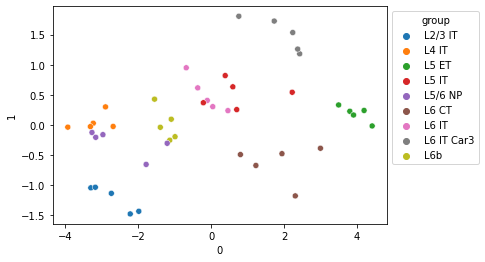

In [108]:
df_proj_2d= pd.DataFrame(proj_2d)


df_proj_2d['classt'] = features.index.get_level_values('classt')
df_proj_2d['group'] = features.index.get_level_values('group')
#df_proj_2d = df_proj_2d[df_proj_2d['classt'] == 'GABAergic']
df_proj_2d = df_proj_2d[df_proj_2d['classt'] == 'Glutamatergic']
#df_proj_2d['classt'] = [class_dict[x] if x in class_dict.keys() else 'miss' for x in df_proj_2d['group']]
ax=sns.scatterplot(
    df_proj_2d[0],df_proj_2d[1],
    hue=df_proj_2d['group'],
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))


<ipython-input-22-37f3b307d73b>:20: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  df_dist[[np.arange(df_dist.shape[0])]*2] = 0


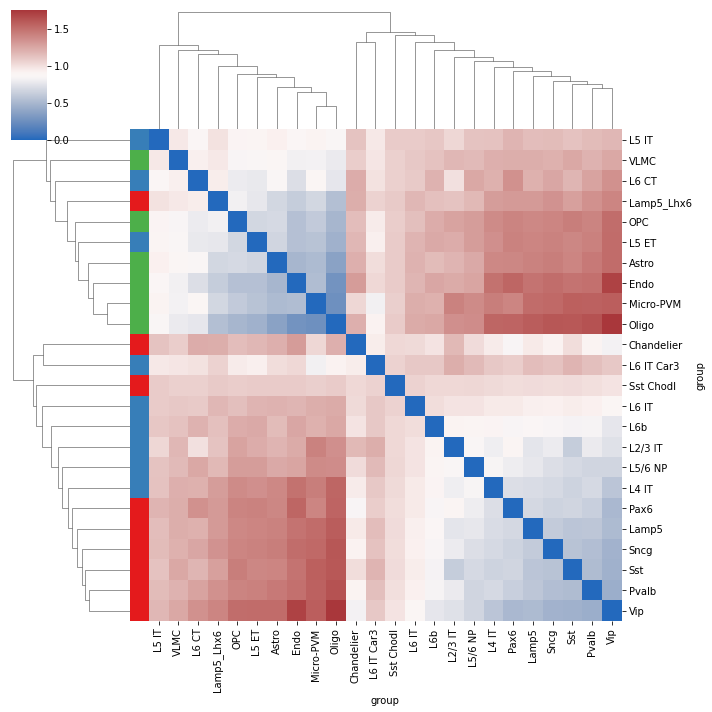

In [22]:
#dj = pd.concat(df_list)
#dk = pd.concat(df_list)
dk = df_gene_tp_all_info_mean
lut = dict(zip( dk.index.get_level_values('classt').drop_duplicates(), sns.color_palette("Set1", dk.index.get_level_values('classt').shape[0]).as_hex()[:]))


row_colors =dk.index.get_level_values('classt').map(lut)



features = dk.loc[:, pure_bins]
#features = dk.loc[:, bins_intersect]
#features = dk.loc[:, :]
features = features.dropna(axis=0)
#features = features.loc[:, dk_max[dk_max>5].index.tolist()]
features_sc =  StandardScaler().fit_transform(features)
R1 = np.round(np.corrcoef(features_sc), 10)
import scipy.spatial as sp, scipy.cluster.hierarchy as hc
df_dist = 1-R1
df_dist[[np.arange(df_dist.shape[0])]*2] = 0
linkage = hc.linkage(sp.distance.squareform(df_dist), method='average')
df_dist_df = pd.DataFrame(df_dist,  index=features.index.get_level_values('group'), columns = features.index.get_level_values('group'))

sns.clustermap(df_dist_df, row_linkage=linkage, col_linkage=linkage, cmap="vlag", row_colors=row_colors)




/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


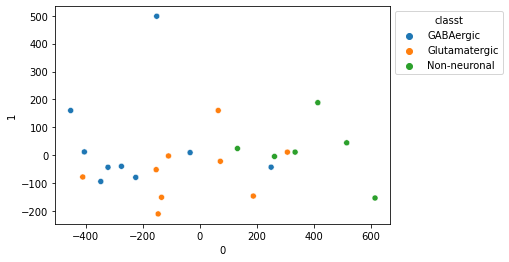

In [86]:
from umap import UMAP
import plotly.express as px
from sklearn.preprocessing import StandardScaler



#umap_2d = UMAP(n_components=2, init='random', random_state=1)


#proj_2d = umap_2d.fit_transform(1-R1)

from sklearn.decomposition import PCA
pca = PCA(n_components=3, random_state=1)
proj_2d = pca.fit_transform(features_sc)


df_proj_2d= pd.DataFrame(proj_2d)


df_proj_2d['classt'] = features.index.get_level_values('classt')
#df_proj_2d = df_proj_2d[df_proj_2d['classt'] = 'Glutamatergic']
#df_proj_2d['classt'] = [class_dict[x] if x in class_dict.keys() else 'miss' for x in df_proj_2d['group']]
ax=sns.scatterplot(
    df_proj_2d[0],df_proj_2d[1],
    hue=df_proj_2d['classt'],
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))


/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


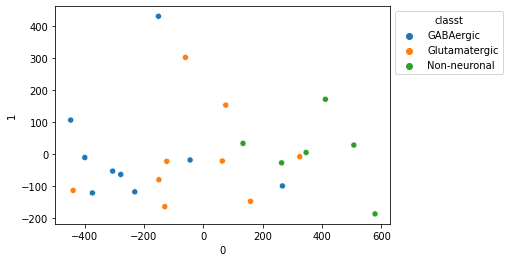

In [74]:
from umap import UMAP
import plotly.express as px
from sklearn.preprocessing import StandardScaler



#umap_2d = UMAP(n_components=2, init='random', random_state=1)


#proj_2d = umap_2d.fit_transform(1-R1)

from sklearn.decomposition import PCA
pca = PCA(n_components=3, random_state=1)
proj_2d = pca.fit_transform(features_sc)


df_proj_2d= pd.DataFrame(proj_2d)


df_proj_2d['classt'] = features.index.get_level_values('classt')
#df_proj_2d = df_proj_2d[df_proj_2d['classt'] = 'Glutamatergic']
#df_proj_2d['classt'] = [class_dict[x] if x in class_dict.keys() else 'miss' for x in df_proj_2d['group']]
ax=sns.scatterplot(
    df_proj_2d[0],df_proj_2d[1],
    hue=df_proj_2d['classt'],
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))


In [24]:
full_input_path = f'/grid/gillis/data_norepl/lohia/hi_c_data_processing/data_human/aggregates/10kbp_raw/max/'
full_target_path = f'/grid/gillis/data_norepl/lohia/hi_c_data_processing/data_mouse/aggregates/10kbp_raw/max/'

os.system(f"~/.conda/envs/hicexplorer/bin/bedtools intersect -wo -b {full_input_path}/all_bins_true_minmatch0.1_mouse.bed -a {full_target_path}/all_bins_true.bed > {full_target_path}/all_bins_true_minmatch0.1_mouse_intersect.bed")
          

df_human_mouse_bins = pd.read_csv(f'{full_target_path}/all_bins_true_minmatch0.1_mouse_intersect.bed', sep='\t', names=['a', 'b', 'c', 'mouse_bin', 'a1', 'b1', 'c1', 'human_bin', 'overlap'])



df_human_mouse_bins['length'] = df_human_mouse_bins['c1'] - df_human_mouse_bins['b1']



df_human_mouse_bins = df_human_mouse_bins.sort_values(['overlap'], ascending=False).drop_duplicates(subset=['human_bin']).drop_duplicates(subset=['mouse_bin'])



df_human_mouse_bins.to_csv('./human_mouse_bin.csv')



In [179]:
df_human_mouse_bins = pd.read_csv('./human_mouse_bin.csv')


human_bins = list(set(df_human_mouse_bins['human_bin']).intersection(pure_bins))

dj = pd.concat(df_list)

#dj = dj.reset_index()
#dj = dj[dj['classt']!='Otheer']
#dj['classt'] = ['Non-neuronal' if x =='Other' else x for x in dj['classt']]
#dk = dj.groupby(['classt','group']).mean()


dj.loc[:,human_bins].to_csv('./human_features.csv')

In [171]:
dk  = pd.concat(df_list)

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


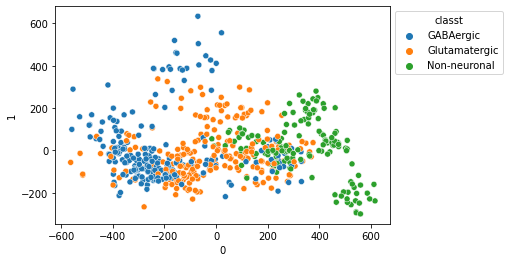

In [172]:
from umap import UMAP
import plotly.express as px
from sklearn.preprocessing import StandardScaler

features = dk.loc[:, :]
#features = dk.loc[:, bins_intersect]
#features = dk.loc[:, :]
features = features.dropna(axis=0)
#features = features.loc[:, dk_max[dk_max>5].index.tolist()]
features_sc =  StandardScaler().fit_transform(features)

#umap_2d = UMAP(n_components=2, init='random', random_state=1)


#proj_2d = umap_2d.fit_transform(1-R1)

from sklearn.decomposition import PCA
pca = PCA(n_components=3, random_state=1)
proj_2d = pca.fit_transform(features_sc)


df_proj_2d= pd.DataFrame(proj_2d)


df_proj_2d['classt'] = features.index.get_level_values('classt')
#df_proj_2d = df_proj_2d[df_proj_2d['classt'] = 'Glutamatergic']
#df_proj_2d['classt'] = [class_dict[x] if x in class_dict.keys() else 'miss' for x in df_proj_2d['group']]
ax=sns.scatterplot(
    df_proj_2d[0],df_proj_2d[1],
    hue=df_proj_2d['classt'],
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))


/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


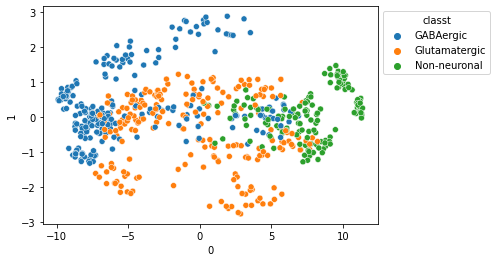

In [177]:
from umap import UMAP
import plotly.express as px
from sklearn.preprocessing import StandardScaler

df_human_mouse_bins = pd.read_csv('./human_mouse_bin.csv')


human_bins = list(set(df_human_mouse_bins['human_bin']).intersection(pure_bins))

features = dk.loc[:, human_bins]
#features = dk.loc[:, bins_intersect]
#features = dk.loc[:, :]
features = features.dropna(axis=0)
#features = features.loc[:, dk_max[dk_max>5].index.tolist()]
features_sc =  StandardScaler().fit_transform(features)
R1 = np.round(np.corrcoef(features_sc), 10)
#umap_2d = UMAP(n_components=2, init='random', random_state=1)


#proj_2d = umap_2d.fit_transform(1-R1)

from sklearn.decomposition import PCA
pca = PCA(n_components=3, random_state=1)
proj_2d = pca.fit_transform(R1)


df_proj_2d= pd.DataFrame(proj_2d)


df_proj_2d['classt'] = features.index.get_level_values('classt')
#df_proj_2d = df_proj_2d[df_proj_2d['classt'] = 'Glutamatergic']
#df_proj_2d['classt'] = [class_dict[x] if x in class_dict.keys() else 'miss' for x in df_proj_2d['group']]
ax=sns.scatterplot(
    df_proj_2d[0],df_proj_2d[1],
    hue=df_proj_2d['classt'],
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))


/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


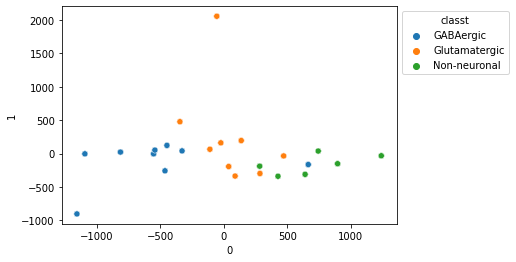

In [66]:
from umap import UMAP
import plotly.express as px
from sklearn.preprocessing import StandardScaler



#umap_2d = UMAP(n_components=2, init='random', random_state=1)


#proj_2d = umap_2d.fit_transform(1-R1)

from sklearn.decomposition import PCA
pca = PCA(n_components=3, random_state=1)
proj_2d = pca.fit_transform(features_sc)


df_proj_2d= pd.DataFrame(proj_2d)


df_proj_2d['classt'] = features.index.get_level_values('classt')
#df_proj_2d = df_proj_2d[df_proj_2d['classt'] = 'Glutamatergic']
#df_proj_2d['classt'] = [class_dict[x] if x in class_dict.keys() else 'miss' for x in df_proj_2d['group']]
ax=sns.scatterplot(
    df_proj_2d[0],df_proj_2d[1],
    hue=df_proj_2d['classt'],
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))


/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


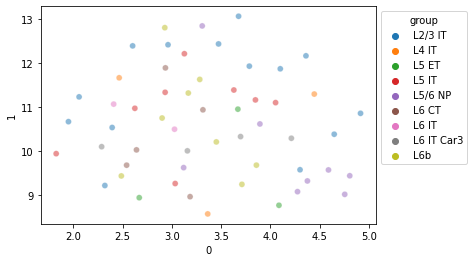

In [52]:
df_proj_2d['classt'] = features.index.get_level_values('classt')
df_proj_2d['group'] = features.index.get_level_values('group')
ax=sns.scatterplot(
    df_proj_2d[0],df_proj_2d[1],
    hue=df_proj_2d['group'],alpha=0.5
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))



<ipython-input-75-073a3cbb06d1>:19: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  df_dist[[np.arange(df_dist.shape[0])]*2] = 0


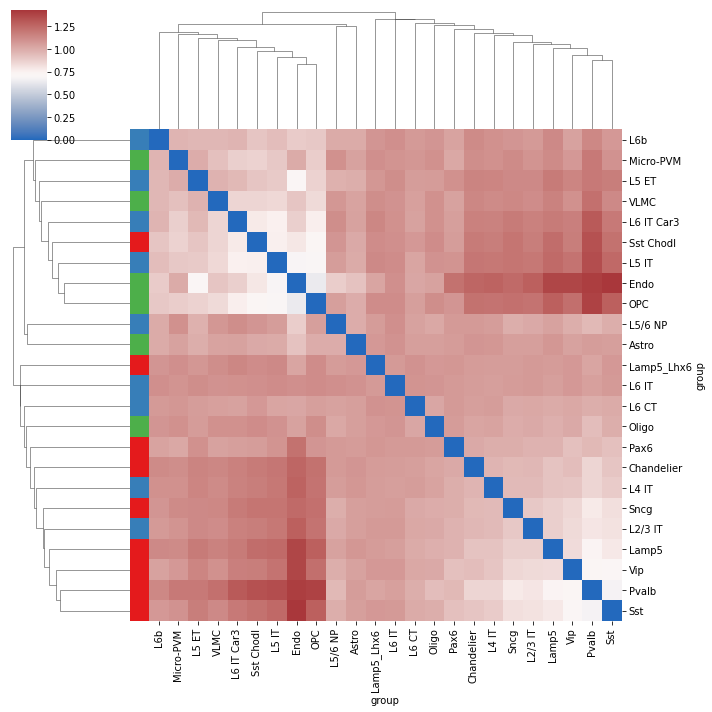

In [75]:
dj = df_gene_tp_all_info_mean
dj = dj.reset_index()
dj = dj[dj['classt']!='Otheer']
dk = dj.groupby(['classt','group']).mean()
lut = dict(zip( dk.index.get_level_values('classt').drop_duplicates(), sns.color_palette("Set1", dk.index.get_level_values('classt').shape[0]).as_hex()[:]))


row_colors =dk.index.get_level_values('classt').map(lut)



features = dk.loc[:, pure_bins]
features = features.dropna(axis=0)
#features = features.loc[:, dk_max[dk_max>5].index.tolist()]
features_sc =  StandardScaler().fit_transform(features)
R1 = np.round(np.corrcoef(features_sc), 10)
import scipy.spatial as sp, scipy.cluster.hierarchy as hc
df_dist = 1-R1
df_dist[[np.arange(df_dist.shape[0])]*2] = 0
linkage = hc.linkage(sp.distance.squareform(df_dist), method='average')
df_dist_df = pd.DataFrame(df_dist,  index=features.index.get_level_values('group'), columns = features.index.get_level_values('group'))

sns.clustermap(df_dist_df, row_linkage=linkage, col_linkage=linkage, cmap="vlag", row_colors=row_colors)



In [45]:
dj = df_gene_tp_all_info_mean
dj = dj.reset_index()
dj = dj[dj['classt']!='Otheer']
dk = dj.groupby(['classt','group', 'cell_type']).mean()
lut = dict(zip( dk.index.get_level_values('classt').drop_duplicates(), sns.color_palette("Set1", dk.index.get_level_values('classt').shape[0]).as_hex()[:]))


row_colors =dk.index.get_level_values('classt').map(lut)



features = dk.loc[:, pure_bins]
features = features.dropna(axis=0)
#features = features.loc[:, dk_max[dk_max>5].index.tolist()]
features_sc =  StandardScaler().fit_transform(features)
R1 = np.round(np.corrcoef(features_sc), 10)
import scipy.spatial as sp, scipy.cluster.hierarchy as hc
df_dist = 1-R1
df_dist[[np.arange(df_dist.shape[0])]*2] = 0
linkage = hc.linkage(sp.distance.squareform(df_dist), method='average')
df_dist_df = pd.DataFrame(df_dist,  index=features.index.get_level_values('group'), columns = features.index.get_level_values('group'))

sns.clustermap(df_dist_df, row_linkage=linkage, col_linkage=linkage, cmap="vlag", row_colors=row_colors)



KeyError: 'cell_type'

In [46]:
df_gene_tp_all_info_mean


0         1         2         3         4        \
classt        group                                                          
GABAergic     Chandelier -0.996336 -0.996336 -0.996336 -0.996336 -0.996336   
              Lamp5      -0.947891 -0.947891 -0.947891 -0.947891 -0.947891   
              Lamp5_Lhx6 -0.817473 -0.817473 -0.817473 -0.817473 -0.817473   
              Pax6       -0.959083 -0.959083 -0.959083 -0.959083 -0.959083   
              Pvalb      -0.945001 -0.945001 -0.945001 -0.945001 -0.945001   
              Sncg       -0.915993 -0.915993 -0.915993 -0.915993 -0.915993   
              Sst        -0.905499 -0.905499 -0.905499 -0.905499 -0.905499   
              Sst Chodl  -0.937941 -0.937941 -0.937941 -0.937941 -0.937941   
              Vip        -0.898982 -0.898982 -0.898982 -0.898982 -0.898982   
Glutamatergic L2/3 IT    -0.804836 -0.804836 -0.804836 -0.804836 -0.804836   
              L4 IT      -0.846813 -0.846813 -0.846813 -0.846813 -0.846813   
              L5 ET      -0.890504 -0.890504 -0.890504 -0.890504 -0.890504   
              L5 IT      -0.825292 -0.825292 -0.825292 -0.825292 -0.825292   
              L5/6 NP    -0.844321 -0.844321 -0.844321 -0.844321 -0.844321   
              L6 CT      -0.911240 -0.911240 -0.911240 -0.911240 -0.911240   
              L6 IT      -0.886529 -0.886529 -0.886529 -0.886529 -0.886529   
              L6 IT Car3 -0.907857 -0.907857 -0.907857 -0.907857 -0.907857   
              L6b        -0.871194 -0.871194 -0.871194 -0.871194 -0.871194   
Non-neuronal  Astro      -0.767853 -0.767853 -0.767853 -0.767853 -0.767853   
              Endo       -0.771186 -0.771186 -0.771186 -0.771186 -0.771186   
              Micro-PVM  -0.859538 -0.859538 -0.859538 -0.859538 -0.859538   
              OPC        -0.872718 -0.872718 -0.872718 -0.872718 -0.872718   
              Oligo      -0.793734 -0.793734 -0.793734 -0.793734 -0.793734   
              VLMC       -0.870801 -0.870801 -0.870801 -0.870801 -0.870801   

                           5         6         7         8         9        \
classt        group                                                          
GABAergic     Chandelier -0.996336 -0.996336 -0.996336 -0.996336 -0.996336   
              Lamp5      -0.947891 -0.947891 -0.947891 -0.947891 -0.947891   
              Lamp5_Lhx6 -0.817473 -0.817473 -0.817473 -0.817473 -0.817473   
              Pax6       -0.959083 -0.959083 -0.959083 -0.959083 -0.959083   
              Pvalb      -0.945001 -0.945001 -0.945001 -0.945001 -0.945001   
              Sncg       -0.915993 -0.915993 -0.915993 -0.915993 -0.915993   
              Sst        -0.905499 -0.905499 -0.905499 -0.905499 -0.905499   
              Sst Chodl  -0.937941 -0.937941 -0.937941 -0.937941 -0.937941   
              Vip        -0.898982 -0.898982 -0.898982 -0.898982 -0.898982   
Glutamatergic L2/3 IT    -0.804836 -0.804836 -0.804836 -0.804836 -0.804836   
              L4 IT      -0.846813 -0.846813 -0.846813 -0.846813 -0.846813   
              L5 ET      -0.890504 -0.890504 -0.890504 -0.890504 -0.890504   
              L5 IT      -0.825292 -0.825292 -0.825292 -0.825292 -0.825292   
              L5/6 NP    -0.844321 -0.844321 -0.844321 -0.844321 -0.844321   
              L6 CT      -0.911240 -0.911240 -0.911240 -0.911240 -0.911240   
              L6 IT      -0.886529 -0.886529 -0.886529 -0.886529 -0.886529   
              L6 IT Car3 -0.907857 -0.907857 -0.907857 -0.907857 -0.907857   
              L6b        -0.871194 -0.871194 -0.871194 -0.871194 -0.871194   
Non-neuronal  Astro      -0.767853 -0.767853 -0.767853 -0.767853 -0.767853   
              Endo       -0.771186 -0.771186 -0.771186 -0.771186 -0.771186   
              Micro-PVM  -0.859538 -0.859538 -0.859538 -0.859538 -0.859538   
              OPC        -0.872718 -0.872718 -0.872718 -0.872718 -0.872718   
              Oligo      -0.793734 -0.793734 -0.793734 -0.793734 -0.793734   
              VLMC       -0.870801 -0.870801 -0.

In [ ]:
df_human_mouse_bins = pd.read_csv('./human_mouse_bin.csv')


human_bins = list(set(df_human_mouse_bins['human_bin']).intersection(pure_bins))


df_gene_tp_all_info_mean.loc[:,human_bins].to_csv('./human_features.csv')


In [31]:
features


793       794       795       796       797      \
classt        group                                                          
GABAergic     Chandelier  0.362401  0.016082 -0.320243 -0.126469 -0.088139   
              Lamp5       0.111175 -0.013445 -0.406398 -0.266252 -0.202310   
              Lamp5_Lhx6  0.611868  0.176489 -0.198284 -0.034195  0.173038   
              Pax6        0.220783 -0.214173 -0.290417 -0.047872  0.016612   
              Pvalb       0.299392 -0.058238 -0.267023 -0.074392 -0.094251   
              Sncg        0.355400  0.005856 -0.356420 -0.255332 -0.222907   
              Sst         0.347751 -0.031220 -0.233320 -0.137813 -0.045516   
              Sst Chodl   0.341086 -0.052587 -0.216088 -0.163342  0.084582   
              Vip         0.212139 -0.004039 -0.321202 -0.150499 -0.168677   
Glutamatergic L2/3 IT     0.278380  0.009539 -0.309453 -0.164460 -0.099746   
              L4 IT       0.183361  0.202971 -0.392126 -0.195939 -0.138113   
              L5 ET       0.547875  0.149982 -0.226108 -0.025703 -0.022000   
              L5 IT       0.361109  0.005157 -0.207005 -0.046186  0.010810   
              L5/6 NP     0.306133 -0.105821 -0.370068 -0.238194 -0.099754   
              L6 CT       0.269772 -0.049005 -0.114383  0.033434 -0.119939   
              L6 IT       0.310557 -0.096835 -0.127009  0.059621 -0.088234   
              L6 IT Car3  0.435551  0.070977 -0.253665  0.085009 -0.066565   
              L6b         0.313878 -0.057004 -0.327877 -0.149928  0.101843   
Non-neuronal  Astro       0.261668  0.006744 -0.150857  0.009855 -0.059267   
              Endo        0.457007 -0.004726 -0.197206  0.036210  0.082802   
              Micro-PVM   0.434545  0.034826 -0.150135 -0.092485  0.049517   
              OPC         0.350390 -0.090665 -0.255635 -0.136469 -0.066742   
              Oligo       0.460597  0.087403 -0.130170  0.003769 -0.013303   
              VLMC        0.463517  0.106588 -0.174842 -0.067333 -0.088589   

                           798       799       800       801       802      \
classt        group                                                          
GABAergic     Chandelier -0.070393 -0.053113 -0.071179 -0.049447 -0.185407   
              Lamp5      -0.134314 -0.170137 -0.080537 -0.107453 -0.131731   
              Lamp5_Lhx6 -0.063256 -0.113046  0.147113  0.082178 -0.135963   
              Pax6       -0.359106 -0.049655 -0.067954 -0.036343 -0.308248   
              Pvalb      -0.248177 -0.107967 -0.084158 -0.006163 -0.002930   
              Sncg       -0.310307 -0.017956 -0.153633 -0.010544 -0.083294   
              Sst        -0.266009 -0.096282 -0.029109  0.039718 -0.048134   
              Sst Chodl  -0.194900 -0.102317 -0.162408  0.282397 -0.166042   
              Vip        -0.265533 -0.119943 -0.073750 -0.025149 -0.129726   
Glutamatergic L2/3 IT    -0.255591  0.087036 -0.089406  0.013689  0.008852   
              L4 IT      -0.113369 -0.096133  0.253589  0.037086  0.082202   
              L5 ET      -0.225913  0.003766 -0.054706  0.080769 -0.009198   
              L5 IT      -0.169258 -0.007961 -0.074713  0.086235  0.007145   
              L5/6 NP    -0.344896 -0.082412 -0.086745  0.037717 -0.075194   
              L6 CT      -0.146344  0.008106  0.088700 -0.014442  0.033526   
              L6 IT      -0.098640 -0.108887 -0.040922  0.066906  0.253085   
              L6 IT Car3 -0.134312  0.025035 -0.043131  0.086440  0.091252   
              L6b        -0.258289  0.015598 -0.073740  0.023218 -0.089003   
Non-neuronal  Astro      -0.103738 -0.003468 -0.012410  0.203981 -0.034548   
              Endo       -0.083597  0.024576  0.160383  0.105481  0.105294   
              Micro-PVM  -0.166065  0.217836  0.162784  0.227873  0.001728   
              OPC        -0.153865  0.023756  0.194230  0.347373 -0.132494   
              Oligo      -0.184736  0.050823  0.079491  0.175213  0.033324   
              VLMC       -0.172458 -0.119424  0.

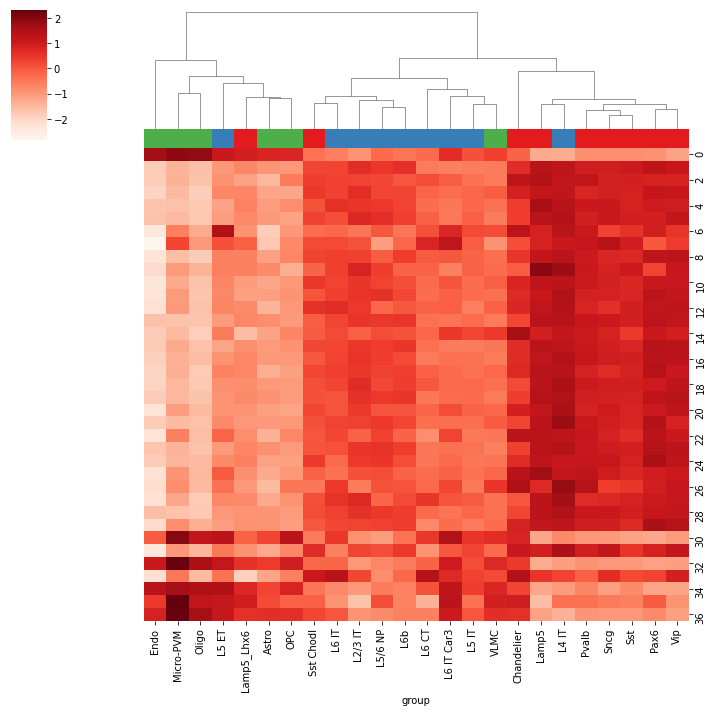

In [69]:

df_hba_modules = pd.read_csv(f'{base_folder}/hi_c_data_processing/data_human/{SRP_name}/{resolution}/cre_modules.bed', sep='\t', names=['c','d', 'e', 'f', 'ccre', 'chr', 'start', 'end', 'bin_id'])


df_hba_modules = df_hba_modules.drop_duplicates(['bin_id'], keep=False)
all_bins = []
mean_list = []
all_bins = []
for i in list(range(1,38)):
    m="M"+str(i)
    given_bins = df_hba_modules[df_hba_modules['ccre']==m]['bin_id'].tolist()
    all_bins.extend(given_bins)
    all_bins.extend(given_bins)
    mean_list.append(dk.loc[: , given_bins].mean(axis=1).values.tolist())
features_sc =  StandardScaler().fit_transform((np.vstack(mean_list)).T)
mean_list_df = pd.DataFrame(features_sc.T , columns = dk.index.get_level_values('group'))

sns.clustermap(mean_list_df, col_cluster=True, row_cluster=False, robust=False, z_score=0, col_colors=[row_colors], cmap='Reds')


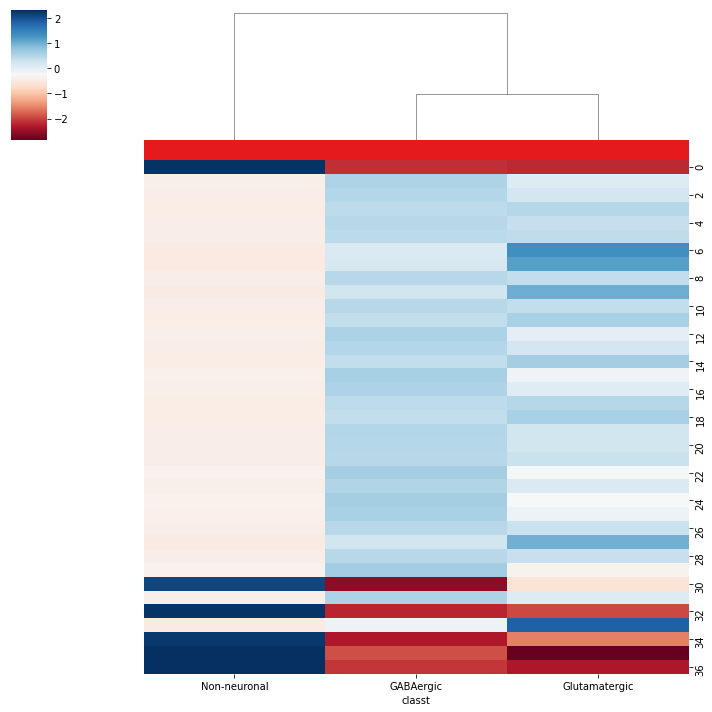

In [342]:

df_hba_modules = pd.read_csv(f'{base_folder}/hi_c_data_processing/data_human/{SRP_name}/{resolution}/cre_modules.bed', sep='\t', names=['c','d', 'e', 'f', 'ccre', 'chr', 'start', 'end', 'bin_id'])

df_hba_modules = df_hba_modules.drop_duplicates(['bin_id'], keep=False)
all_bins = []
mean_list = []
all_bins = []
for i in list(range(1,38)):
    m="M"+str(i)
    given_bins = df_hba_modules[df_hba_modules['ccre']==m]['bin_id'].tolist()
    all_bins.extend(given_bins)
    all_bins.extend(given_bins)
    mean_list.append(dk_mean.loc[: , given_bins].mean(axis=1).values.tolist())
features_sc =  StandardScaler().fit_transform((np.vstack(mean_list)).T)
mean_list_df = pd.DataFrame(features_sc.T , columns = dk_mean.index.get_level_values('classt'))

sns.clustermap(mean_list_df, col_cluster=True, row_cluster=False, robust=False, z_score=1, col_colors=[row_colors], cmap='RdBu')


In [350]:
dk_mean

0         1         2         3         4         5       \
classt                                                                      
GABAergic     -1.367141 -0.775990 -1.204819 -1.028178 -1.013486 -0.320686   
Glutamatergic -1.336278 -0.718120 -1.184391 -0.996928 -0.977785 -0.262872   
Non-neuronal  -1.269643 -0.633862 -1.110434 -0.928135 -0.940145 -0.209963   

                 6         7         8         9       ...    287499  \
classt                                                 ...             
GABAergic     -0.433594 -0.642313 -0.311255 -0.701841  ... -1.029433   
Glutamatergic -0.289906 -0.573807 -0.155511 -0.633973  ... -0.989074   
Non-neuronal  -0.286940 -0.510080 -0.172714 -0.591116  ... -0.939883   

                 287500    287501    287502    287503    287504    287505  \
classt                                                                      
GABAergic     -1.225391 -1.127520 -1.355484 -0.662226  0.159702 -0.233987   
Glutamatergic -1.198262 -1.107167 -1.330723 -0.594922  0.294704 -0.144786   
Non-neuronal  -1.138501 -1.052423 -1.260340 -0.539070  0.436748 -0.020988   

                 287506    287507    287508  
classt                                       
GABAergic     -0.294482 -0.963501 -1.374072  
Glutamatergic -0.208879 -0.921276 -1.342061  
Non-neuronal  -0.108855 -0.869013 -1.273419  

[3 rows x 287509 columns]

In [355]:
dk_mean.T['Non-neuronal'].mean()

-0.0025340800639241934

In [356]:
dk_mean.T['GABAergic'].mean()

-0.003209050977602601

In [357]:
dk_mean.T['Glutamatergic'].mean()

-0.003212464042007923

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<Axes: xlabel='GABAergic'>

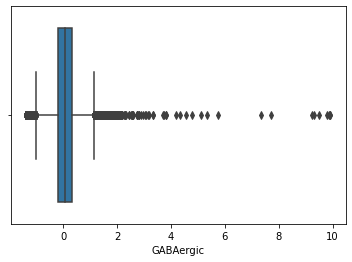

In [349]:
sns.boxplot(dk_mean.T['GABAergic'])

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<Axes: xlabel='Non-neuronal'>

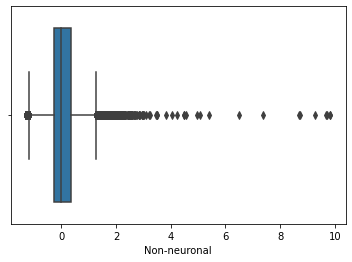

In [351]:
sns.boxplot(dk_mean.T['Non-neuronal'])

In [338]:
dk_mean = dk.groupby(['classt']).mean()

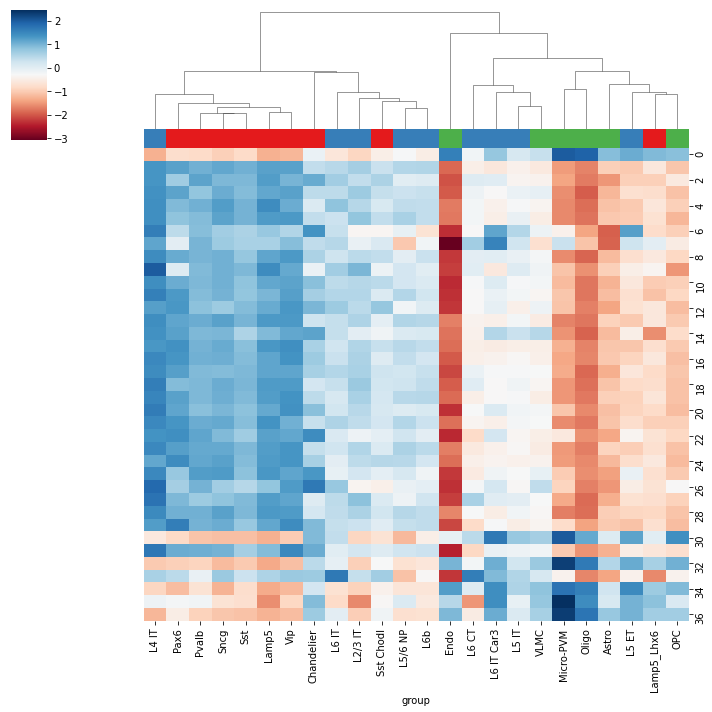

In [332]:
sns.clustermap(mean_list_df, col_cluster=True, row_cluster=False, robust=False, col_colors=[row_colors], cmap='RdBu')


In [318]:
df_hba_modules = pd.read_csv(f'{base_folder}/hi_c_data_processing/data_human/{SRP_name}/{resolution}/cre_modules.bed', sep='\t', names=['c','d', 'e', 'f', 'ccre', 'chr', 'start', 'end', 'bin_id'])


In [319]:
df_hba_modules

c          d          e            f ccre   chr      start  \
0       chr1       9848      10000       cCRE_1  M36  chr1          0   
1       chr1      10000      10347       cCRE_1  M36  chr1      10000   
2       chr1     180570     181069       cCRE_2  M32  chr1     180000   
3       chr1     191227     191726       cCRE_3  M35  chr1     190000   
4       chr1     267759     268258       cCRE_4  M23  chr1     260000   
...      ...        ...        ...          ...  ...   ...        ...   
553108  chr9  138126097  138126596  cCRE_526852  M23  chr9  138120000   
553109  chr9  138150025  138150524  cCRE_526853  M36  chr9  138150000   
553110  chr9  138177079  138177578  cCRE_526854  M23  chr9  138170000   
553111  chr9  138208974  138209473  cCRE_526855   M5  chr9  138200000   
553112  chr9  138216811  138217310  cCRE_526856  M33  chr9  138210000   

              end  bin_id  
0           10000       0  
1           20000       1  
2          190000      18  
3          200000      19  
4          270000      26  
...           ...     ...  
553108  138130000  167464  
553109  138160000  167467  
553110  138180000  167469  
553111  138210000  167472  
553112  138220000  167473  

[553113 rows x 9 columns]

In [53]:
dl = df_gene_tp_all_info_mean
dl = dl.reset_index()
dj = dl[dl['classt']!='Glutamatergicm']
dk = dj.groupby(['classt','group']).mean()
features = dk.loc[:, pure_bins]
features = features.dropna(axis=1)
#features = dk.loc[:, :]
features_sc =  StandardScaler().fit_transform(features)

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


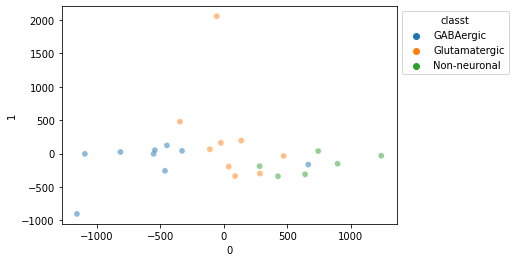

In [54]:
#umap_2d = UMAP(n_components=2, init='random', random_state=10)


#proj_2d = umap_2d.fit_transform(features_sc)

#df_proj_2d= pd.DataFrame(proj_2d)


from sklearn.decomposition import PCA
pca = PCA(n_components=2)
proj_2d = pca.fit_transform(features_sc)
df_proj_2d= pd.DataFrame(proj_2d)

df_proj_2d['classt'] = features.index.get_level_values('classt')
ax=sns.scatterplot(
    df_proj_2d[0],df_proj_2d[1],
    hue=df_proj_2d['classt'],alpha=0.5
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


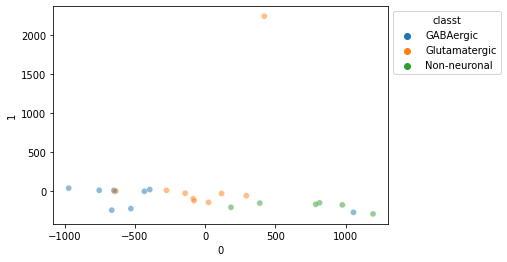

In [217]:
df_proj_2d['classt'] = features.index.get_level_values('classt')
ax=sns.scatterplot(
    df_proj_2d[0],df_proj_2d[1],
    hue=df_proj_2d['classt'],alpha=0.5
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


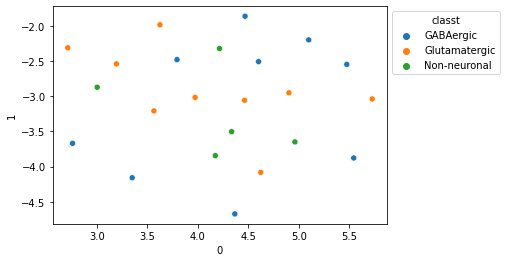

In [302]:
df_proj_2d['classt'] = features.index.get_level_values('classt')
ax=sns.scatterplot(
    df_proj_2d[0],df_proj_2d[1],
    hue=df_proj_2d['classt'],
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


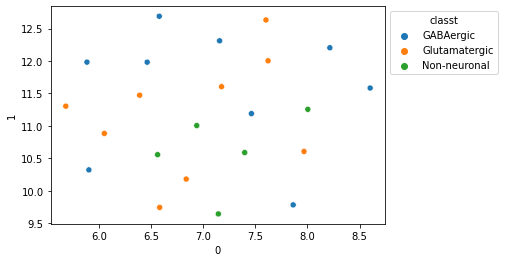

In [299]:
df_proj_2d['classt'] = features.index.get_level_values('classt')
ax=sns.scatterplot(
    df_proj_2d[0],df_proj_2d[1],
    hue=df_proj_2d['classt'],
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

In [122]:
#df_gene_tp_all_info_mean = df_gene_tp_all_info.groupby(['classt','group', 'cell_type']).mean().reset_index().groupby(['classt','group']).mean()
df_gene_tp_all_info_mean = df_gene_tp_all_info.groupby(['classt','group']).mean()

In [123]:
all_bins_mean = df_gene_tp_all_info_mean.mean(axis=0)

all_bins_std = df_gene_tp_all_info_mean.std(axis=0)

In [199]:
all_marker_1 = list(np.arange(1,300, 3, dtype='int'))

all_marker_2 = list(np.arange(2,300, 3, dtype='int'))

all_marker_3 = list(np.arange(3,300, 3, dtype='int'))

In [215]:
m_list = list(range(200))
all_marker_1_more = [[random.choice(m_list) for i in list(range(0,100))] for i in range(0,5)]

In [ ]:
import random
marker_mean_list = []
#for marker_iter in [all_marker_1, all_marker_2]:
#for marker_iter in all_marker_1_more:
for marker_iter_st in list(range(0,1)):
    number_of_genes_list = [10, 50, 100, 150, 200, 250, 500, 1000]
    marker_level_list = ['class', 'subclass', 'type']

    number_of_genes_list = [10]
    marker_level_list = ['type']

    for number_of_genes in number_of_genes_list:
        for marker_level in marker_level_list:
            
            


            marker_list = pd.read_csv(f'{base_folder}/hi_c_data_processing/notebooks/metamarkers/human/{marker_level}_markers_top1000.csv.gz', skiprows=1)

            marker_list['gene'] = marker_list['gene'].str.upper()
            df_ensg_name = pd.read_csv(f'{base_folder}/hi_c_data_processing/genomes_jlee/ensg_geneid_symbol.csv', sep='\t')[['Ensembl_gene_identifier', 'Symbol']]
            marker_list = marker_list.merge(df_ensg_name.drop_duplicates(), right_on='Symbol', left_on='gene') 
            marker_list = marker_list[marker_list['Ensembl_gene_identifier'].isin(gene_list)]
            #marker_list = marker_list.sort_values(by='rank')
            #marker_list = marker_list.sort_values(by='rank').drop_duplicates(subset=['Ensembl_gene_identifier'])
            marker_list = marker_list[marker_list['rank'] < 200]

            
            if marker_level == 'type':

                marker_list_t = pd.read_csv(f'{base_folder}/hi_c_data_processing/notebooks/metamarkers/human/subclass_markers_top1000.csv.gz', skiprows=1)

                marker_list_t = marker_list_t.drop_duplicates(subset='cell_type')

                marker_list_t.rename(columns = {'group':'classt'}, inplace = True)
                marker_list_t.rename(columns = {'cell_type':'group'}, inplace = True)


                marker_list = marker_list[['Ensembl_gene_identifier', 'group', 'cell_type', 'rank']].merge(marker_list_t[['classt', 'group']])
            
            #marker_list = marker_list.drop_duplicates(subset=['classt','Ensembl_gene_identifier'])
            marker_list = marker_list.drop_duplicates(subset=['group','Ensembl_gene_identifier'])
            #marker_list = marker_list[marker_list['classt']=='GABAergic']
            marker_list = marker_list[marker_list['classt']=='Glutamatergic']

            all_cell_types = marker_list.drop_duplicates(['cell_type'])['cell_type'].tolist()
            all_group_types = marker_list.drop_duplicates(['group'])['group'].tolist()
            df2_list = []
            print (marker_list.groupby('cell_type')['group'].count().head(50))
            
            print (marker_list)



            for group2 in all_cell_types:
                #df2_list.append(marker_list[marker_list['cell_type']==group2].sort_values(by=['rank']).head(200).head(number_of_genes))
                #df2_list.append(marker_list[marker_list['rank'] < number_of_genes])
                m_tmp = marker_list[marker_list['cell_type']==group2]
                m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]
                #print (m_tmp[m_tmp['rank'] < 50].shape)


                #m_tmp = m_tmp[m_tmp['rank'] < 100]
                #print ((m_tmp[m_tmp['adj_rank'].isin(list(marker_iter))]).shape[0])
                
                
                print (group2, m_tmp['adj_rank'].max())
                if m_tmp['adj_rank'].max() > 1:
                    all_marker_1 = list(np.arange(0,m_tmp['adj_rank'].max(), 1, dtype='int'))
                    #marker_iter = [random.choice(all_marker_1) for i in list(range(0,m_tmp['adj_rank'].max()))]
                    marker_iter = [random.choice(all_marker_1) for i in list(range(0,10))]
                    #marker_iter_tmp = [x for x in list(marker_iter) if x<= m_tmp['adj_rank'].max() ]
                

                    df2_list.append(m_tmp[m_tmp['adj_rank'].isin(list(all_marker_1))])
                    
                    #df2_list.append(m_tmp.iloc[marker_iter])
                    #df2_list.append(m_tmp.iloc[marker_iter])


            marker_list=pd.concat(df2_list)
            #marker_list['adj_rank'] = [i for i in list(range(0,marker_list.shape[0]))]
            #marker_list=marker_list[marker_list['adj_rank'].isin(list(marker_iter))]
            #marker_list = marker_list.sort_values(by='rank').drop_duplicates(subset=['Ensembl_gene_identifier', 'group'])
            #marker_list = marker_list[marker_list['rank'] <= number_of_genes] 

            #marker_list = marker_list[marker_list['auroc'] >= 0.85] 
            #marker_list = marker_list[marker_list.group.isin(['Sst'])]

            #marker_list = marker_list[marker_list.cell_type.isin(['Pvalb_1', 'Pvalb_2'])]
            #marker_list = marker_list.drop_duplicates(subset=['gene'], keep=False)

            #m_number_of_genes = number_of_genes +20
            #marker_list = marker_list[marker_list['rank'] < m_number_of_genes]
            #marker_list = marker_list.sort_values(by=['rank'])
            #print (marker_list)


            marker_table = marker_list.pivot_table(index='Ensembl_gene_identifier', columns='cell_type', values='rank', aggfunc='sum')

            marker_table.fillna(0, inplace=True)

            marker_table[marker_table != 0] = 1



    if marker_level == 'subclass':
        marker_list.rename(columns = {'group':'classt'}, inplace = True)
        marker_list.rename(columns = {'cell_type':'group'}, inplace = True)
        marker_list['cell_type'] = marker_list['group'].tolist()


    marker_list = marker_list.sample(frac=1)

    marker_list = marker_list[['classt', 'group', 'cell_type', 'Ensembl_gene_identifier']]

    df_gene_tp = pd.DataFrame(my_data_zcore ,  index=gene_list, columns = bins_bed['bin_id'].tolist())

    df_gene_tp = df_gene_tp.loc[marker_list['Ensembl_gene_identifier'].tolist(), :]

    df_gene_tp_all_info = df_gene_tp.merge(marker_list, left_on=df_gene_tp.index, right_on=marker_list['Ensembl_gene_identifier'])

    df_gene_tp_all_info = df_gene_tp_all_info.set_index('key_0')

    df_gene_tp_all_info = df_gene_tp_all_info.drop(columns=['Ensembl_gene_identifier'])



    #df_gene_tp_all_info_mean = df_gene_tp_all_info.groupby(['classt','group', 'cell_type']).mean().reset_index().groupby(['classt','group']).mean()
    df_gene_tp_all_info_mean = df_gene_tp_all_info.groupby(['classt','group', 'cell_type']).mean()
    #df_gene_tp_all_info_mean = df_gene_tp_all_info.groupby(['classt','group']).mean()
    marker_mean_list.append(df_gene_tp_all_info_mean)


/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


cell_type
L2/3 IT_1       160
L2/3 IT_10      138
L2/3 IT_11       99
L2/3 IT_12       70
L2/3 IT_13      105
L2/3 IT_14      112
L2/3 IT_2        99
L2/3 IT_3        87
L2/3 IT_4        28
L2/3 IT_5        33
L2/3 IT_6        81
L2/3 IT_7        64
L2/3 IT_8        43
L2/3 IT_9        95
L4 IT_1         145
L4 IT_2         134
L4 IT_3         132
L5 ET_1         165
L5 ET_2         169
L5 ET_3         166
L5 IT_1         156
L5 IT_2         151
L5 IT_3         157
L5 IT_4          71
L5 IT_5         124
L5 IT_6          85
L5 IT_7          40
L5 IT_8          62
L5/6 NP_1       163
L5/6 NP_2       151
L5/6 NP_3       138
L5/6 NP_4       122
L5/6 NP_5        90
L5/6 NP_6       117
L5/6 NP_7        55
L5/6 NP_8        42
L6 CT_1         172
L6 CT_2         139
L6 CT_3         141
L6 CT_4         153
L6 CT_5          91
L6 IT Car3_1    163
L6 IT Car3_2    141
L6 IT Car3_3    164
L6 IT Car3_4    122
L6 IT_1         153
L6 IT_2         167
L6b_1           160
L6b_2            72
L6b_3     

<ipython-input-30-2c1d536aa53c>:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_tmp['adj_rank'] = [i for i in list(range(0,m_tmp.shape[0]))]


<ipython-input-19-74f31b1143f4>:26: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  df_dist[[np.arange(df_dist.shape[0])]*2] = 0


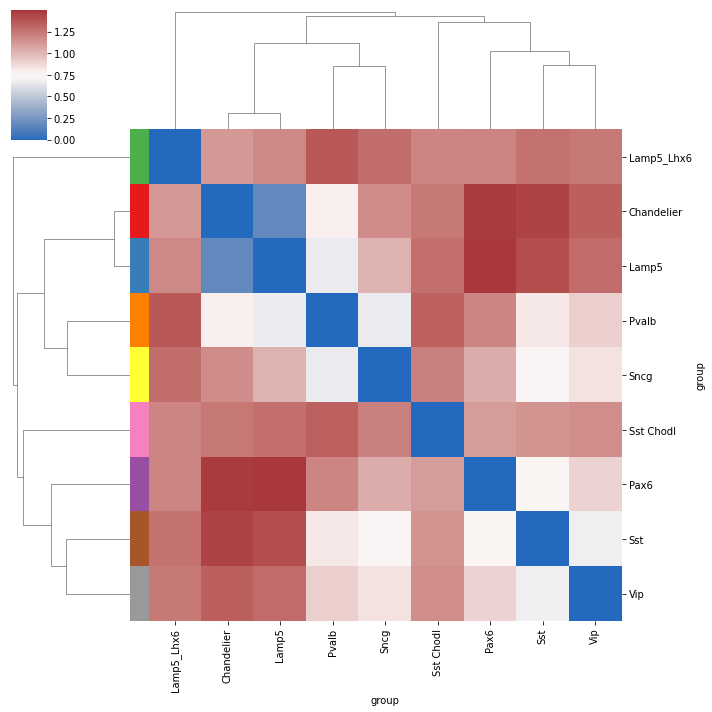

In [19]:
from umap import UMAP
import plotly.express as px
from sklearn.preprocessing import StandardScaler

df_hba_modules = pd.read_csv(f'{base_folder}/hi_c_data_processing/data_human/{SRP_name}/{resolution}/cre_modules.bed', sep='\t', names=['c','d', 'e', 'f', 'ccre', 'chr', 'start', 'end', 'bin_id'])


df_hba_modules = df_hba_modules.drop_duplicates(['bin_id'], keep=False)
dj = pd.concat(marker_mean_list)
dj = dj.reset_index()
#dj = dj[dj['classt']!='Non-neuronal']
dk = dj.groupby(['classt','group']).mean()

lut = dict(zip( dk.index.get_level_values('group').drop_duplicates(), sns.color_palette("Set1", dk.index.get_level_values('group').shape[0]).as_hex()[:]))


row_colors =dk.index.get_level_values('group').map(lut)



features = dk.loc[:, :]
features_sc =  StandardScaler().fit_transform(features)
R1 = np.round(np.corrcoef(features_sc), 10)
import scipy.spatial as sp, scipy.cluster.hierarchy as hc
df_dist = 1-R1
df_dist[[np.arange(df_dist.shape[0])]*2] = 0
linkage = hc.linkage(sp.distance.squareform(df_dist), method='average')
df_dist_df = pd.DataFrame(df_dist,  index=features.index.get_level_values('group'), columns = features.index.get_level_values('group'))

sns.clustermap(df_dist_df, row_linkage=linkage, col_linkage=linkage, cmap="vlag", row_colors=row_colors)


In [1]:
from umap import UMAP
import plotly.express as px
from sklearn.preprocessing import StandardScaler

df_hba_modules = pd.read_csv(f'{base_folder}/hi_c_data_processing/data_human/{SRP_name}/{resolution}/cre_modules.bed', sep='\t', names=['c','d', 'e', 'f', 'ccre', 'chr', 'start', 'end', 'bin_id'])


df_hba_modules = df_hba_modules.drop_duplicates(['bin_id'], keep=False)
dj = pd.concat(marker_mean_list)
dj = dj.reset_index()
#dj = dj[dj['classt']!='Non-neuronal']
dk = dj.groupby(['classt','group']).mean()

lut = dict(zip( dk.index.get_level_values('group').drop_duplicates(), sns.color_palette("Set1", dk.index.get_level_values('group').shape[0]).as_hex()[:]))


row_colors =dk.index.get_level_values('group').map(lut)



features = dk.loc[:, :]
features_sc =  StandardScaler().fit_transform(features)
R1 = np.round(np.corrcoef(features_sc), 10)
import scipy.spatial as sp, scipy.cluster.hierarchy as hc
df_dist = 1-R1
df_dist[[np.arange(df_dist.shape[0])]*2] = 0
linkage = hc.linkage(sp.distance.squareform(df_dist), method='average')
df_dist_df = pd.DataFrame(df_dist,  index=features.index.get_level_values('group'), columns = features.index.get_level_values('group'))

sns.clustermap(df_dist_df, row_linkage=linkage, col_linkage=linkage, cmap="vlag", row_colors=row_colors)


NameError: name 'pd' is not defined

In [124]:
lut = dict(zip( df_gene_tp_all_info_mean.index.get_level_values('classt').drop_duplicates(), sns.color_palette("Set1", df_gene_tp_all_info_mean.index.get_level_values('classt').shape[0]).as_hex()[:]))


row_colors =df_gene_tp_all_info_mean.index.get_level_values('classt').map(lut)


In [125]:
from umap import UMAP
import plotly.express as px
from sklearn.preprocessing import StandardScaler

In [169]:
df_gene_tp_all_info_mean = df_gene_tp_all_info.groupby(['classt','group']).mean()

In [223]:
dj

0         1         2         3         4        \
classt        group                                                          
GABAergic     Chandelier -1.136939 -1.136939 -1.136939 -1.136939 -1.136939   
              Lamp5      -1.236200 -1.236200 -1.236200 -1.236200 -1.236200   
              Lamp5_Lhx6 -1.117338 -1.117338 -1.117338 -1.117338 -1.117338   
              Pax6       -1.161391 -1.161391 -1.161391 -1.161391 -1.161391   
              Pvalb      -1.159489 -1.159489 -1.159489 -1.159489 -1.159489   
              Sncg       -1.152952 -1.152952 -1.152952 -1.152952 -1.152952   
              Sst        -1.101333 -1.101333 -1.101333 -1.101333 -1.101333   
              Sst Chodl  -1.108935 -1.108935 -1.108935 -1.108935 -1.108935   
              Vip        -1.111711 -1.111711 -1.111711 -1.111711 -1.111711   
Glutamatergic L2/3 IT    -1.108780 -1.108780 -1.108780 -1.108780 -1.108780   
              L4 IT      -1.196050 -1.196050 -1.196050 -1.196050 -1.196050   
              L5 ET      -0.986197 -0.986197 -0.986197 -0.986197 -0.986197   
              L5 IT      -1.064799 -1.064799 -1.064799 -1.064799 -1.064799   
              L5/6 NP    -1.153001 -1.153001 -1.153001 -1.153001 -1.153001   
              L6 CT      -1.122397 -1.122397 -1.122397 -1.122397 -1.122397   
              L6 IT      -1.150222 -1.150222 -1.150222 -1.150222 -1.150222   
              L6 IT Car3 -1.212391 -1.212391 -1.212391 -1.212391 -1.212391   
              L6b        -1.167293 -1.167293 -1.167293 -1.167293 -1.167293   
Non-neuronal  Astro      -1.019331 -1.019331 -1.019331 -1.019331 -1.019331   
              Endo       -0.924028 -0.924028 -0.924028 -0.924028 -0.924028   
              Micro-PVM  -1.196533 -1.196533 -1.196533 -1.196533 -1.196533   
              OPC        -1.059687 -1.059687 -1.059687 -1.059687 -1.059687   
              Oligo      -1.014279 -1.014279 -1.014279 -1.014279 -1.014279   
              VLMC       -0.801605 -0.801605 -0.801605 -0.801605 -0.801605   

                           5         6         7         8         9        \
classt        group                                                          
GABAergic     Chandelier -1.136939 -1.136939 -1.136939 -1.136939 -1.136939   
              Lamp5      -1.236200 -1.236200 -1.236200 -1.236200 -1.236200   
              Lamp5_Lhx6 -1.117338 -1.117338 -1.117338 -1.117338 -1.117338   
              Pax6       -1.161391 -1.161391 -1.161391 -1.161391 -1.161391   
              Pvalb      -1.159489 -1.159489 -1.159489 -1.159489 -1.159489   
              Sncg       -1.152952 -1.152952 -1.152952 -1.152952 -1.152952   
              Sst        -1.101333 -1.101333 -1.101333 -1.101333 -1.101333   
              Sst Chodl  -1.108935 -1.108935 -1.108935 -1.108935 -1.108935   
              Vip        -1.111711 -1.111711 -1.111711 -1.111711 -1.111711   
Glutamatergic L2/3 IT    -1.108780 -1.108780 -1.108780 -1.108780 -1.108780   
              L4 IT      -1.196050 -1.196050 -1.196050 -1.196050 -1.196050   
              L5 ET      -0.986197 -0.986197 -0.986197 -0.986197 -0.986197   
              L5 IT      -1.064799 -1.064799 -1.064799 -1.064799 -1.064799   
              L5/6 NP    -1.153001 -1.153001 -1.153001 -1.153001 -1.153001   
              L6 CT      -1.122397 -1.122397 -1.122397 -1.122397 -1.122397   
              L6 IT      -1.150222 -1.150222 -1.150222 -1.150222 -1.150222   
              L6 IT Car3 -1.212391 -1.212391 -1.212391 -1.212391 -1.212391   
              L6b        -1.167293 -1.167293 -1.167293 -1.167293 -1.167293   
Non-neuronal  Astro      -1.019331 -1.019331 -1.019331 -1.019331 -1.019331   
              Endo       -0.924028 -0.924028 -0.924028 -0.924028 -0.924028   
              Micro-PVM  -1.196533 -1.196533 -1.196533 -1.196533 -1.196533   
              OPC        -1.059687 -1.059687 -1.059687 -1.059687 -1.059687   
              Oligo      -1.014279 -1.014279 -1.014279 -1.014279 -1.014279   
              VLMC       -0.801605 -0.801605 -0.

In [225]:
from umap import UMAP
import plotly.express as px
from sklearn.preprocessing import StandardScaler

dj = pd.concat(marker_mean_list)
dj = df_gene_tp_all_info.groupby(['classt','group', 'cell_type']).mean()

#features = df.loc[:, :2875001]
#features = df_gene_tp.loc[:, :]
#features = df_gene_tp.loc[:, bins_bed_cre[bins_bed_cre['cre'] >= 3]['bin_id'].tolist()]




ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

In [234]:
dj

0         1         2         3        \
classt       group      cell_type                                              
GABAergic    Chandelier Chandelier_1 -1.304194 -1.304194 -1.304194 -1.304194   
                        Chandelier_2 -1.053312 -1.053312 -1.053312 -1.053312   
             Lamp5      Lamp5_1      -1.217027 -1.217027 -1.217027 -1.217027   
                        Lamp5_2      -1.263900 -1.263900 -1.263900 -1.263900   
                        Lamp5_3      -1.297502 -1.297502 -1.297502 -1.297502   
...                                        ...       ...       ...       ...   
Non-neuronal Oligo      Oligo_7      -0.305396 -0.305396 -0.305396 -0.305396   
                        Oligo_8      -1.109376 -1.109376 -1.109376 -1.109376   
                        Oligo_9      -1.065301 -1.065301 -1.065301 -1.065301   
             VLMC       VLMC_1       -1.058647 -1.058647 -1.058647 -1.058647   
                        VLMC_2       -0.630243 -0.630243 -0.630243 -0.630243   

                                       4         5         6         7        \
classt       group      cell_type                                              
GABAergic    Chandelier Chandelier_1 -1.304194 -1.304194 -1.304194 -1.304194   
                        Chandelier_2 -1.053312 -1.053312 -1.053312 -1.053312   
             Lamp5      Lamp5_1      -1.217027 -1.217027 -1.217027 -1.217027   
                        Lamp5_2      -1.263900 -1.263900 -1.263900 -1.263900   
                        Lamp5_3      -1.297502 -1.297502 -1.297502 -1.297502   
...                                        ...       ...       ...       ...   
Non-neuronal Oligo      Oligo_7      -0.305396 -0.305396 -0.305396 -0.305396   
                        Oligo_8      -1.109376 -1.109376 -1.109376 -1.109376   
                        Oligo_9      -1.065301 -1.065301 -1.065301 -1.065301   
             VLMC       VLMC_1       -1.058647 -1.058647 -1.058647 -1.058647   
                        VLMC_2       -0.630243 -0.630243 -0.630243 -0.630243   

                                       8         9        ...   2875002  \
classt       group      cell_type                         ...             
GABAergic    Chandelier Chandelier_1 -1.304194 -1.304194  ... -1.289411   
                        Chandelier_2 -1.053312 -1.053312  ... -1.053312   
             Lamp5      Lamp5_1      -1.217027 -1.217027  ... -1.217027   
                        Lamp5_2      -1.263900 -1.263900  ... -1.263900   
                        Lamp5_3      -1.297502 -1.297502  ... -1.297502   
...                                        ...       ...  ...       ...   
Non-neuronal Oligo      Oligo_7      -0.305396 -0.305396  ... -0.305396   
                        Oligo_8      -1.109376 -1.109376  ... -0.560833   
                        Oligo_9      -1.065301 -1.065301  ... -1.065301   
             VLMC       VLMC_1       -1.058647 -1.058647  ... -1.100227   
                        VLMC_2       -0.630243 -0.630243  ... -0.630243   

                                       2875003   2875004   2875005   2875006  \
classt       group      cell_type                                              
GABAergic    Chandelier Chandelier_1 -1.289411 -1.289411 -1.289411 -1.289411   
                        Chandelier_2 -1.053312 -1.053312 -1.053312 -1.053312   
             Lamp5      Lamp5_1      -1.217027 -1.217027 -1.217027 -1.217027   
                        Lamp5_2      -1.263900 -1.263900 -1.263900 -1.263900   
                        Lamp5_3      -1.297502 -1.297502 -1.297502 -1.297502   
...                                        ...       ...       ...       ...   
Non-neuronal Oligo      Oligo_7      -0.305396 -0.305396 -0.305396 -0.305396   
                        Oligo_8      -0.560833 -0.560833 -0.560833 -0.560833   
                        Oligo_9      -1.065301 -1.065301 -1.065301 -1.065301   
             VLMC       VLMC_1       -1.100227 -1.100227 -1.100227 -1.100227   
                     

In [235]:
features = dj.loc[:, all_bins_std[all_bins_std >=0.0].index.tolist()]
features = features.dropna()
features_sc =  StandardScaler().fit_transform(features)
umap_2d = UMAP(n_components=2, init='random', random_state=20)


proj_2d = umap_2d.fit_transform(features_sc)



/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


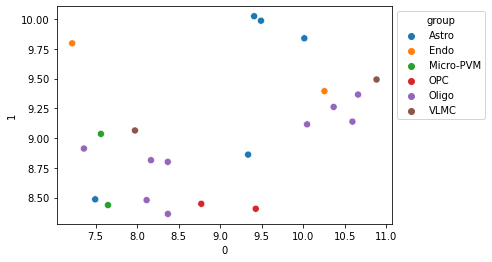

In [239]:

df_proj_2d= pd.DataFrame(proj_2d)
df_proj_2d['classt'] = dj.dropna().index.get_level_values('classt')
df_proj_2d['group'] = dj.dropna().index.get_level_values('group')
df_proj_2d = df_proj_2d[df_proj_2d['classt'] == 'Non-neuronal']
ax=sns.scatterplot(
    df_proj_2d[0],df_proj_2d[1],
    hue=df_proj_2d['group'], s=50
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

In [ ]:
features = dj.loc[:, all_bins_std[all_bins_std >=0.05].index.tolist()]

features_sc =  StandardScaler().fit_transform(features)
umap_2d = UMAP(n_components=2, init='random', random_state=20)


proj_2d = umap_2d.fit_transform(features_sc)

df_proj_2d= pd.DataFrame(proj_2d)

df_proj_2d['group'] = dj.index.get_level_values('classt')
ax=sns.scatterplot(
    df_proj_2d[0],df_proj_2d[1],
    hue=df_proj_2d['group'], s=50
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

In [227]:
features.dropna()

0         1         2         3        \
classt       group      cell_type                                              
GABAergic    Chandelier Chandelier_1 -1.304194 -1.304194 -1.304194 -1.304194   
                        Chandelier_2 -1.053312 -1.053312 -1.053312 -1.053312   
             Lamp5      Lamp5_1      -1.217027 -1.217027 -1.217027 -1.217027   
                        Lamp5_2      -1.263900 -1.263900 -1.263900 -1.263900   
                        Lamp5_3      -1.297502 -1.297502 -1.297502 -1.297502   
...                                        ...       ...       ...       ...   
Non-neuronal Oligo      Oligo_7      -0.305396 -0.305396 -0.305396 -0.305396   
                        Oligo_8      -1.109376 -1.109376 -1.109376 -1.109376   
                        Oligo_9      -1.065301 -1.065301 -1.065301 -1.065301   
             VLMC       VLMC_1       -1.058647 -1.058647 -1.058647 -1.058647   
                        VLMC_2       -0.630243 -0.630243 -0.630243 -0.630243   

                                       4         5         6         7        \
classt       group      cell_type                                              
GABAergic    Chandelier Chandelier_1 -1.304194 -1.304194 -1.304194 -1.304194   
                        Chandelier_2 -1.053312 -1.053312 -1.053312 -1.053312   
             Lamp5      Lamp5_1      -1.217027 -1.217027 -1.217027 -1.217027   
                        Lamp5_2      -1.263900 -1.263900 -1.263900 -1.263900   
                        Lamp5_3      -1.297502 -1.297502 -1.297502 -1.297502   
...                                        ...       ...       ...       ...   
Non-neuronal Oligo      Oligo_7      -0.305396 -0.305396 -0.305396 -0.305396   
                        Oligo_8      -1.109376 -1.109376 -1.109376 -1.109376   
                        Oligo_9      -1.065301 -1.065301 -1.065301 -1.065301   
             VLMC       VLMC_1       -1.058647 -1.058647 -1.058647 -1.058647   
                        VLMC_2       -0.630243 -0.630243 -0.630243 -0.630243   

                                       8         9        ...   2875002  \
classt       group      cell_type                         ...             
GABAergic    Chandelier Chandelier_1 -1.304194 -1.304194  ... -1.289411   
                        Chandelier_2 -1.053312 -1.053312  ... -1.053312   
             Lamp5      Lamp5_1      -1.217027 -1.217027  ... -1.217027   
                        Lamp5_2      -1.263900 -1.263900  ... -1.263900   
                        Lamp5_3      -1.297502 -1.297502  ... -1.297502   
...                                        ...       ...  ...       ...   
Non-neuronal Oligo      Oligo_7      -0.305396 -0.305396  ... -0.305396   
                        Oligo_8      -1.109376 -1.109376  ... -0.560833   
                        Oligo_9      -1.065301 -1.065301  ... -1.065301   
             VLMC       VLMC_1       -1.058647 -1.058647  ... -1.100227   
                        VLMC_2       -0.630243 -0.630243  ... -0.630243   

                                       2875003   2875004   2875005   2875006  \
classt       group      cell_type                                              
GABAergic    Chandelier Chandelier_1 -1.289411 -1.289411 -1.289411 -1.289411   
                        Chandelier_2 -1.053312 -1.053312 -1.053312 -1.053312   
             Lamp5      Lamp5_1      -1.217027 -1.217027 -1.217027 -1.217027   
                        Lamp5_2      -1.263900 -1.263900 -1.263900 -1.263900   
                        Lamp5_3      -1.297502 -1.297502 -1.297502 -1.297502   
...                                        ...       ...       ...       ...   
Non-neuronal Oligo      Oligo_7      -0.305396 -0.305396 -0.305396 -0.305396   
                        Oligo_8      -0.560833 -0.560833 -0.560833 -0.560833   
                        Oligo_9      -1.065301 -1.065301 -1.065301 -1.065301   
             VLMC       VLMC_1       -1.100227 -1.100227 -1.100227 -1.100227   
                     

In [228]:
features

0         1         2         3        \
classt       group      cell_type                                              
GABAergic    Chandelier Chandelier_1 -1.304194 -1.304194 -1.304194 -1.304194   
                        Chandelier_2 -1.053312 -1.053312 -1.053312 -1.053312   
             Lamp5      Lamp5_1      -1.217027 -1.217027 -1.217027 -1.217027   
                        Lamp5_2      -1.263900 -1.263900 -1.263900 -1.263900   
                        Lamp5_3      -1.297502 -1.297502 -1.297502 -1.297502   
...                                        ...       ...       ...       ...   
Non-neuronal Oligo      Oligo_7      -0.305396 -0.305396 -0.305396 -0.305396   
                        Oligo_8      -1.109376 -1.109376 -1.109376 -1.109376   
                        Oligo_9      -1.065301 -1.065301 -1.065301 -1.065301   
             VLMC       VLMC_1       -1.058647 -1.058647 -1.058647 -1.058647   
                        VLMC_2       -0.630243 -0.630243 -0.630243 -0.630243   

                                       4         5         6         7        \
classt       group      cell_type                                              
GABAergic    Chandelier Chandelier_1 -1.304194 -1.304194 -1.304194 -1.304194   
                        Chandelier_2 -1.053312 -1.053312 -1.053312 -1.053312   
             Lamp5      Lamp5_1      -1.217027 -1.217027 -1.217027 -1.217027   
                        Lamp5_2      -1.263900 -1.263900 -1.263900 -1.263900   
                        Lamp5_3      -1.297502 -1.297502 -1.297502 -1.297502   
...                                        ...       ...       ...       ...   
Non-neuronal Oligo      Oligo_7      -0.305396 -0.305396 -0.305396 -0.305396   
                        Oligo_8      -1.109376 -1.109376 -1.109376 -1.109376   
                        Oligo_9      -1.065301 -1.065301 -1.065301 -1.065301   
             VLMC       VLMC_1       -1.058647 -1.058647 -1.058647 -1.058647   
                        VLMC_2       -0.630243 -0.630243 -0.630243 -0.630243   

                                       8         9        ...   2875002  \
classt       group      cell_type                         ...             
GABAergic    Chandelier Chandelier_1 -1.304194 -1.304194  ... -1.289411   
                        Chandelier_2 -1.053312 -1.053312  ... -1.053312   
             Lamp5      Lamp5_1      -1.217027 -1.217027  ... -1.217027   
                        Lamp5_2      -1.263900 -1.263900  ... -1.263900   
                        Lamp5_3      -1.297502 -1.297502  ... -1.297502   
...                                        ...       ...  ...       ...   
Non-neuronal Oligo      Oligo_7      -0.305396 -0.305396  ... -0.305396   
                        Oligo_8      -1.109376 -1.109376  ... -0.560833   
                        Oligo_9      -1.065301 -1.065301  ... -1.065301   
             VLMC       VLMC_1       -1.058647 -1.058647  ... -1.100227   
                        VLMC_2       -0.630243 -0.630243  ... -0.630243   

                                       2875003   2875004   2875005   2875006  \
classt       group      cell_type                                              
GABAergic    Chandelier Chandelier_1 -1.289411 -1.289411 -1.289411 -1.289411   
                        Chandelier_2 -1.053312 -1.053312 -1.053312 -1.053312   
             Lamp5      Lamp5_1      -1.217027 -1.217027 -1.217027 -1.217027   
                        Lamp5_2      -1.263900 -1.263900 -1.263900 -1.263900   
                        Lamp5_3      -1.297502 -1.297502 -1.297502 -1.297502   
...                                        ...       ...       ...       ...   
Non-neuronal Oligo      Oligo_7      -0.305396 -0.305396 -0.305396 -0.305396   
                        Oligo_8      -0.560833 -0.560833 -0.560833 -0.560833   
                        Oligo_9      -1.065301 -1.065301 -1.065301 -1.065301   
             VLMC       VLMC_1       -1.100227 -1.100227 -1.100227 -1.100227   
                     

In [217]:
dj = pd.concat(marker_mean_list)
#dj = df_gene_tp_all_info_mean

#dj = df_gene_tp_all_info_mean
dj = dj.reset_index()

#dj = dj[dj['classt']!='Non-neuronal']
#dj = dj[dj['classt']=='GABAergic']
#dj = dj[dj['classt']=='Glutamatergic']


from sklearn.decomposition import PCA
features = dj.loc[:, all_bins_std[all_bins_std >= 0].index.tolist()]
features  = features.dropna(axis=1)
features_sc =  StandardScaler().fit_transform(features)
#pca = PCA(n_components=2)
#proj_2da = pca.fit_transform(features_sc)
umap_2d = UMAP(n_components=2, init='random', random_state=10)
proj_2da = umap_2d.fit_transform(features_sc)
df_proj_2da= pd.DataFrame(proj_2da)
df_proj_2da['classt'] = dj['classt'].tolist()
df_proj_2da['group'] = dj['group'].tolist()


In [195]:
df_proj_2da= pd.DataFrame(proj_2da)
df_proj_2da['classt'] = dj['classt'].tolist()
df_proj_2da['group'] = dj['group'].tolist()

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


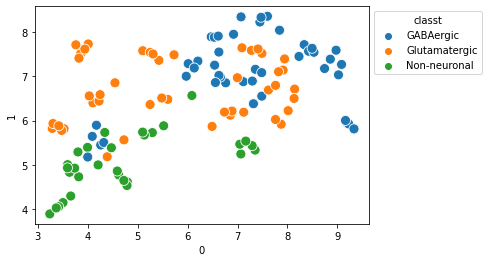

In [218]:

ax= sns.scatterplot(
    df_proj_2da[0], df_proj_2da[1],
    hue=df_proj_2da['classt'],s=100
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


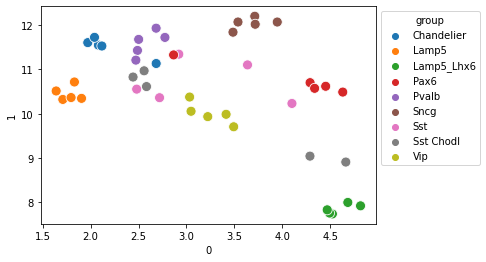

In [213]:
df_proj_2dat = df_proj_2da[df_proj_2da['classt']=='GABAergic']
ax= sns.scatterplot(
    df_proj_2dat[0], df_proj_2dat[1],
    hue=df_proj_2dat['group'],s=100
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


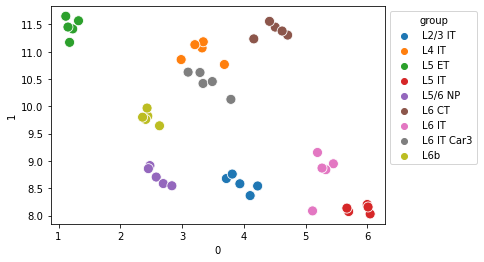

In [214]:
df_proj_2dat = df_proj_2da[df_proj_2da['classt']=='Glutamatergic']
ax= sns.scatterplot(
    df_proj_2dat[0], df_proj_2dat[1],
    hue=df_proj_2dat['group'],s=100
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


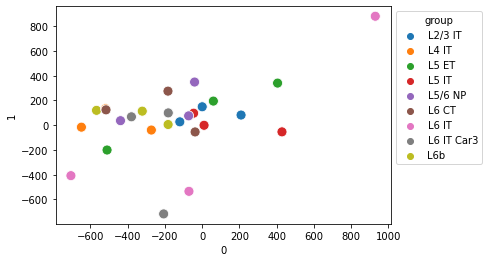

In [189]:
df_proj_2da= pd.DataFrame(proj_2da)
df_proj_2da['classt'] = dj['classt'].tolist()
df_proj_2da['group'] = dj['group'].tolist()
df_proj_2da = df_proj_2da[df_proj_2da['classt']=='Glutamatergic']
ax= sns.scatterplot(
    df_proj_2da[0], df_proj_2da[1],
    hue=df_proj_2da['group'],s=100
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

In [176]:


df_proj_2d['group'] = df_gene_tp_all_info_mean.index.get_level_values('classt')


/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


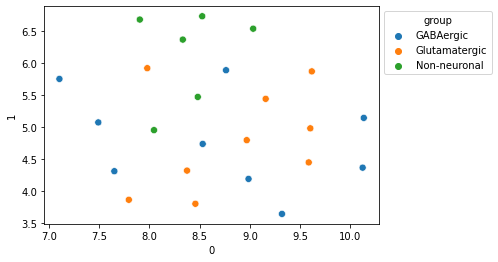

In [177]:
ax=sns.scatterplot(
    df_proj_2d[0],df_proj_2d[1],
    hue=df_proj_2d['group'], s=50
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


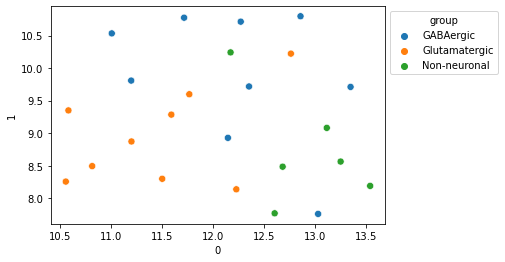

In [172]:
ax=sns.scatterplot(
    df_proj_2d[0],df_proj_2d[1],
    hue=df_proj_2d['group'], s=50
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

In [157]:
df_gene_tp_all_info_mean

0         1         2         3        \
classt       group      cell_type                                              
GABAergic    Chandelier Chandelier_1 -1.180019 -1.180019 -1.180019 -1.180019   
                        Chandelier_2 -0.943137 -0.943137 -0.943137 -0.943137   
             Lamp5      Lamp5_1      -1.083808 -1.083808 -1.083808 -1.083808   
                        Lamp5_2      -1.021739 -1.021739 -1.021739 -1.021739   
                        Lamp5_3      -1.036233 -1.036233 -1.036233 -1.036233   
...                                        ...       ...       ...       ...   
Non-neuronal Oligo      Oligo_7      -0.499861 -0.499861 -0.499861 -0.499861   
                        Oligo_8      -0.935771 -0.935771 -0.935771 -0.935771   
                        Oligo_9      -1.019388 -1.019388 -1.019388 -1.019388   
             VLMC       VLMC_1       -1.050502 -1.050502 -1.050502 -1.050502   
                        VLMC_2       -0.881856 -0.881856 -0.881856 -0.881856   

                                       4         5         6         7        \
classt       group      cell_type                                              
GABAergic    Chandelier Chandelier_1 -1.180019 -1.180019 -1.180019 -1.180019   
                        Chandelier_2 -0.943137 -0.943137 -0.943137 -0.943137   
             Lamp5      Lamp5_1      -1.083808 -1.083808 -1.083808 -1.083808   
                        Lamp5_2      -1.021739 -1.021739 -1.021739 -1.021739   
                        Lamp5_3      -1.036233 -1.036233 -1.036233 -1.036233   
...                                        ...       ...       ...       ...   
Non-neuronal Oligo      Oligo_7      -0.499861 -0.499861 -0.499861 -0.499861   
                        Oligo_8      -0.935771 -0.935771 -0.935771 -0.935771   
                        Oligo_9      -1.019388 -1.019388 -1.019388 -1.019388   
             VLMC       VLMC_1       -1.050502 -1.050502 -1.050502 -1.050502   
                        VLMC_2       -0.881856 -0.881856 -0.881856 -0.881856   

                                       8         9        ...   2875002  \
classt       group      cell_type                         ...             
GABAergic    Chandelier Chandelier_1 -1.180019 -1.180019  ... -1.194689   
                        Chandelier_2 -0.943137 -0.943137  ... -0.964292   
             Lamp5      Lamp5_1      -1.083808 -1.083808  ... -1.092302   
                        Lamp5_2      -1.021739 -1.021739  ... -1.044661   
                        Lamp5_3      -1.036233 -1.036233  ... -1.052276   
...                                        ...       ...  ...       ...   
Non-neuronal Oligo      Oligo_7      -0.499861 -0.499861  ... -0.484658   
                        Oligo_8      -0.935771 -0.935771  ... -0.911353   
                        Oligo_9      -1.019388 -1.019388  ... -1.027203   
             VLMC       VLMC_1       -1.050502 -1.050502  ... -1.024408   
                        VLMC_2       -0.881856 -0.881856  ... -0.883334   

                                       2875003   2875004   2875005   2875006  \
classt       group      cell_type                                              
GABAergic    Chandelier Chandelier_1 -1.194689 -1.194689 -1.194689 -1.194689   
                        Chandelier_2 -0.964292 -0.964292 -0.964292 -0.964292   
             Lamp5      Lamp5_1      -1.092302 -1.092302 -1.092302 -1.092302   
                        Lamp5_2      -1.044661 -1.044661 -1.044661 -1.044661   
                        Lamp5_3      -1.052276 -1.052276 -1.052276 -1.052276   
...                                        ...       ...       ...       ...   
Non-neuronal Oligo      Oligo_7      -0.484658 -0.484658 -0.484658 -0.484658   
                        Oligo_8      -0.911353 -0.911353 -0.911353 -0.911353   
                        Oligo_9      -1.027203 -1.027203 -1.027203 -1.027203   
             VLMC       VLMC_1       -1.024408 -1.024408 -1.024408 -1.024408   
                     

In [161]:
#df_gene_tp_all_info_mean[df_proj_2d['classt']=='Glutamatergic']
dj = df_gene_tp_all_info_mean.reset_index()
dj = dj[dj['classt']=='Glutamatergic']
features = dj.loc[:, all_bins_std[all_bins_std >=0.05].index.tolist()]

features_sc =  StandardScaler().fit_transform(features)

umap_2d = UMAP(n_components=2, init='random', random_state=20)


proj_2d = umap_2d.fit_transform(features_sc)

df_proj_2d= pd.DataFrame(proj_2d)
df_proj_2d['group'] = dj['group'].tolist()
#df_proj_2d['classt'] = df_gene_tp_all_info_mean.index.get_level_values('classt')

In [152]:
df_proj_2da = df_proj_2d[df_proj_2d['classt']=='GABAergic']

In [155]:
df_proj_2da = df_proj_2d[df_proj_2d['classt']=='Glutamatergic']

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


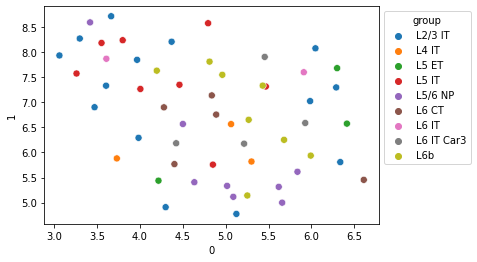

In [163]:
ax=sns.scatterplot(
    df_proj_2d[0],df_proj_2d[1],
    hue=df_proj_2d['group'], s=50
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


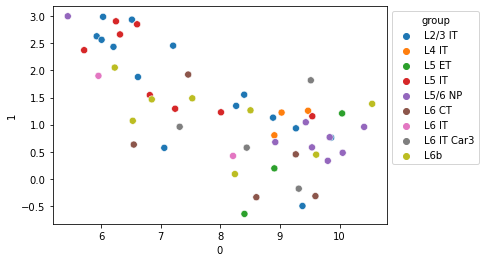

In [156]:
ax=sns.scatterplot(
    df_proj_2da[0],df_proj_2da[1],
    hue=df_proj_2da['group'], s=50
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

In [91]:
umap_2d = UMAP(n_components=2, init='random', random_state=20)


proj_2d = umap_2d.fit_transform(features_sc)

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='0', ylabel='1'>

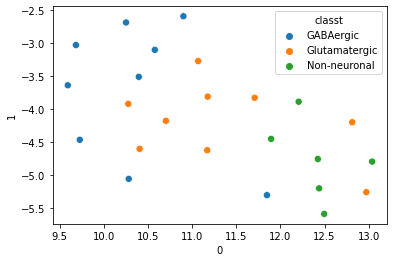

In [92]:
df_proj_2d= pd.DataFrame(proj_2d)

df_proj_2d['classt'] = df_gene_tp_all_info_mean.index.get_level_values('classt')
sns.scatterplot(
    df_proj_2d[0],df_proj_2d[1],
    hue=df_proj_2d['classt'], s=50
)

In [127]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
proj_2d = pca.fit_transform(features_sc)

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='0', ylabel='1'>

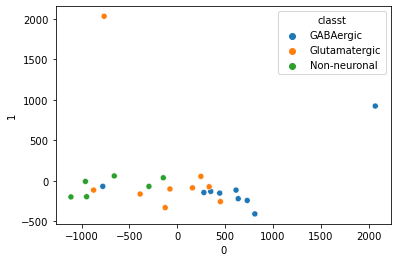

In [128]:
df_proj_2d= pd.DataFrame(proj_2d)

df_proj_2d['classt'] = df_gene_tp_all_info_mean.index.get_level_values('classt')
sns.scatterplot(
    df_proj_2d[0],df_proj_2d[1],
    hue=df_proj_2d['classt'],
)

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='0', ylabel='1'>

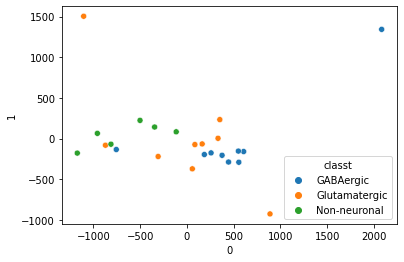

In [110]:
df_proj_2d= pd.DataFrame(proj_2d)

df_proj_2d['classt'] = df_gene_tp_all_info_mean.index.get_level_values('classt')
sns.scatterplot(
    df_proj_2d[0],df_proj_2d[1],
    hue=df_proj_2d['classt'],
)

<ipython-input-93-fade4fa8ee78>:14: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  df_dist[[np.arange(df_dist.shape[0])]*2] = 0


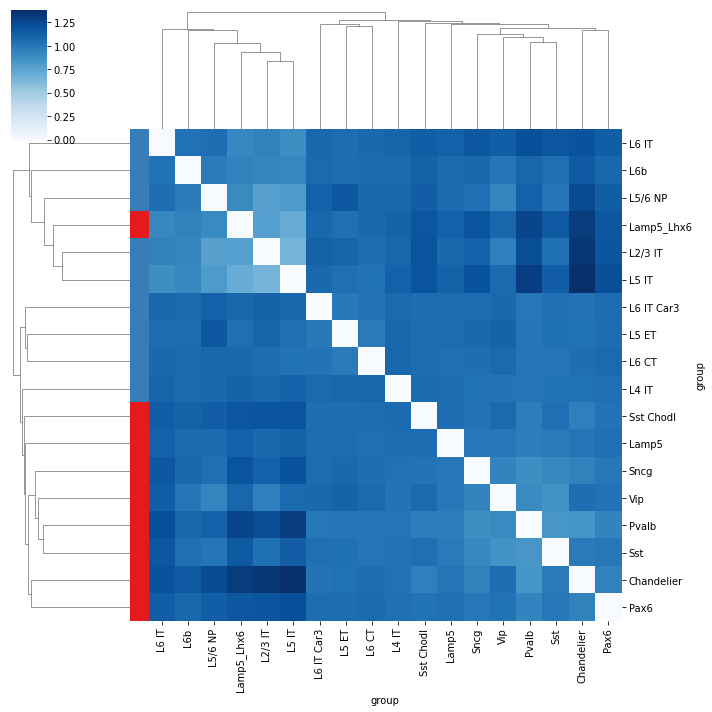

In [93]:


features = df_gene_tp_all_info_mean.loc[:, all_bins_std[all_bins_std >=0].index.tolist()]
#features = pd.concat([features[0:8] , features[19:25]])
features = pd.concat([features[0:18]])
features_sc =  StandardScaler().fit_transform(features)

lut = dict(zip( features.index.get_level_values('classt').drop_duplicates(), sns.color_palette("Set1", df_gene_tp_all_info_mean.index.get_level_values('classt').shape[0]).as_hex()[:]))


row_colors =features.index.get_level_values('classt').map(lut)

R1 = np.round(np.corrcoef(features_sc), 10)
import scipy.spatial as sp, scipy.cluster.hierarchy as hc
df_dist = 1-R1
df_dist[[np.arange(df_dist.shape[0])]*2] = 0
linkage = hc.linkage(sp.distance.squareform(df_dist), method='average')
df_dist_df = pd.DataFrame(df_dist,  index=features.index.get_level_values('group'), columns = features.index.get_level_values('group'))

sns.clustermap(df_dist_df, row_linkage=linkage, col_linkage=linkage, cmap="Blues", row_colors=row_colors)


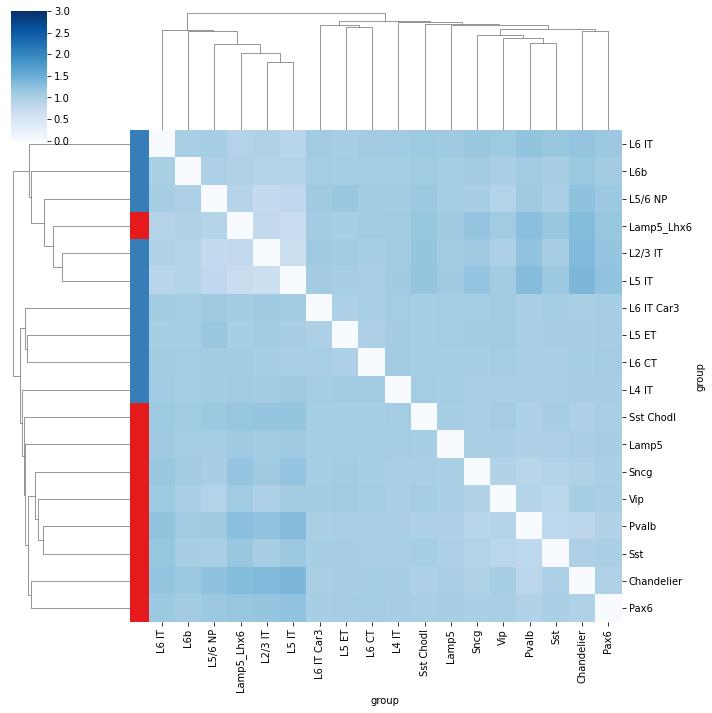

In [96]:
sns.clustermap(df_dist_df, row_linkage=linkage, col_linkage=linkage, cmap="Blues", row_colors=row_colors, vmax=3)

<ipython-input-111-1b3efc6a3540>:14: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  df_dist[[np.arange(df_dist.shape[0])]*2] = 0


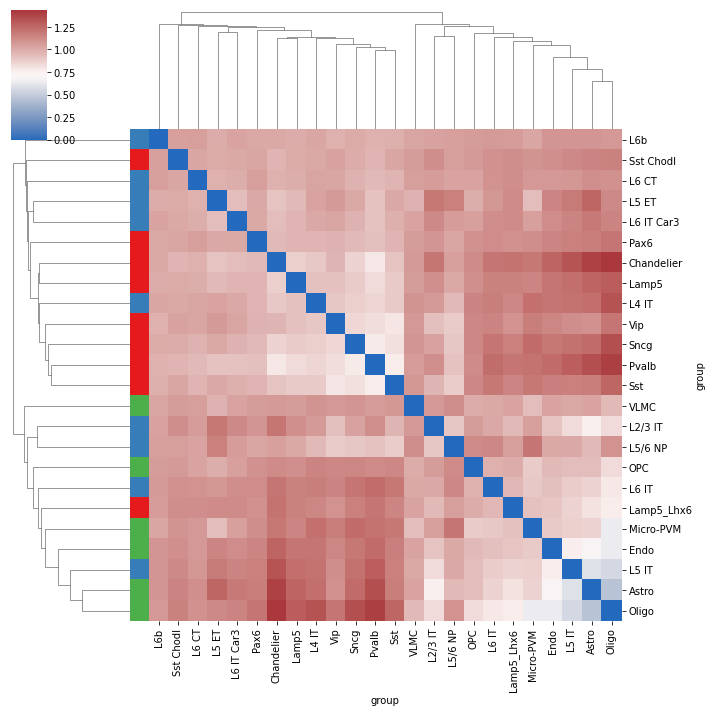

In [111]:
features = df_gene_tp_all_info_mean.loc[:, all_bins_std[all_bins_std >=0].index.tolist()]
#features = pd.concat([features[0:8] , features[19:25]])

features_sc =  StandardScaler().fit_transform(features)

lut = dict(zip( features.index.get_level_values('classt').drop_duplicates(), sns.color_palette("Set1", df_gene_tp_all_info_mean.index.get_level_values('classt').shape[0]).as_hex()[:]))


row_colors =features.index.get_level_values('classt').map(lut)

R1 = np.round(np.corrcoef(features_sc), 10)
import scipy.spatial as sp, scipy.cluster.hierarchy as hc
df_dist = 1-R1
df_dist[[np.arange(df_dist.shape[0])]*2] = 0
linkage = hc.linkage(sp.distance.squareform(df_dist), method='average')
df_dist_df = pd.DataFrame(df_dist,  index=features.index.get_level_values('group'), columns = features.index.get_level_values('group'))

sns.clustermap(df_dist_df, row_linkage=linkage, col_linkage=linkage, cmap="vlag", row_colors=row_colors)


<ipython-input-129-1b3efc6a3540>:14: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  df_dist[[np.arange(df_dist.shape[0])]*2] = 0


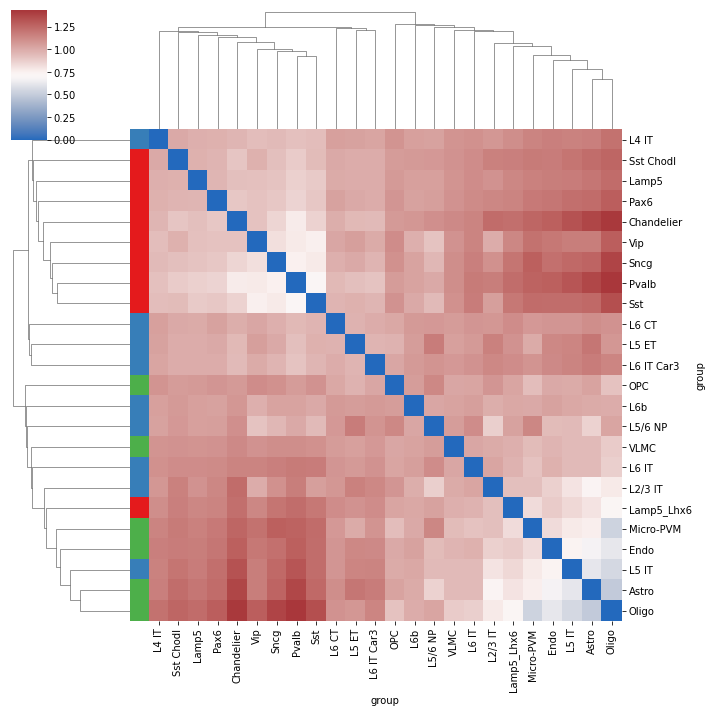

In [129]:
features = df_gene_tp_all_info_mean.loc[:, all_bins_std[all_bins_std >=0].index.tolist()]
#features = pd.concat([features[0:8] , features[19:25]])

features_sc =  StandardScaler().fit_transform(features)

lut = dict(zip( features.index.get_level_values('classt').drop_duplicates(), sns.color_palette("Set1", df_gene_tp_all_info_mean.index.get_level_values('classt').shape[0]).as_hex()[:]))


row_colors =features.index.get_level_values('classt').map(lut)

R1 = np.round(np.corrcoef(features_sc), 10)
import scipy.spatial as sp, scipy.cluster.hierarchy as hc
df_dist = 1-R1
df_dist[[np.arange(df_dist.shape[0])]*2] = 0
linkage = hc.linkage(sp.distance.squareform(df_dist), method='average')
df_dist_df = pd.DataFrame(df_dist,  index=features.index.get_level_values('group'), columns = features.index.get_level_values('group'))

sns.clustermap(df_dist_df, row_linkage=linkage, col_linkage=linkage, cmap="vlag", row_colors=row_colors)


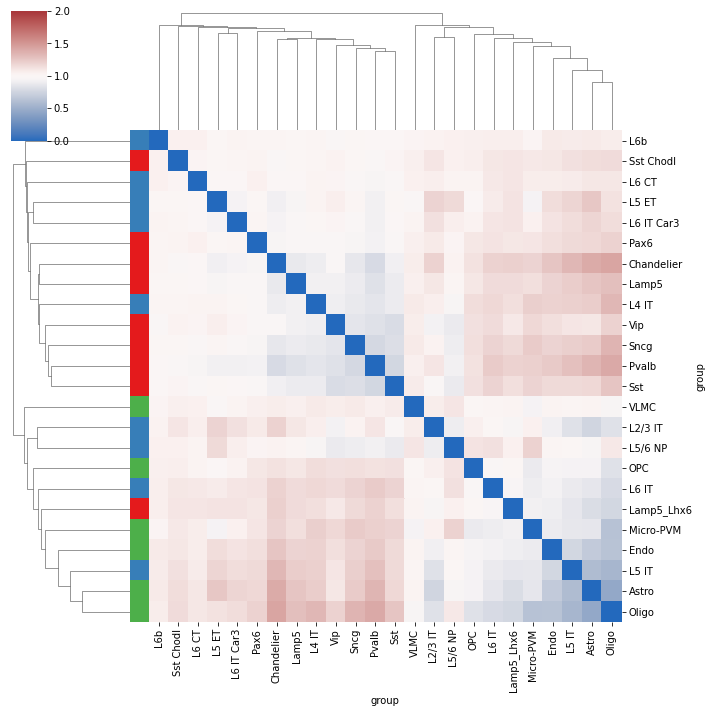

In [116]:
sns.clustermap(df_dist_df, row_linkage=linkage, col_linkage=linkage, cmap="vlag", row_colors=row_colors, vmax=2)


In [112]:
a

NameError: name 'a' is not defined

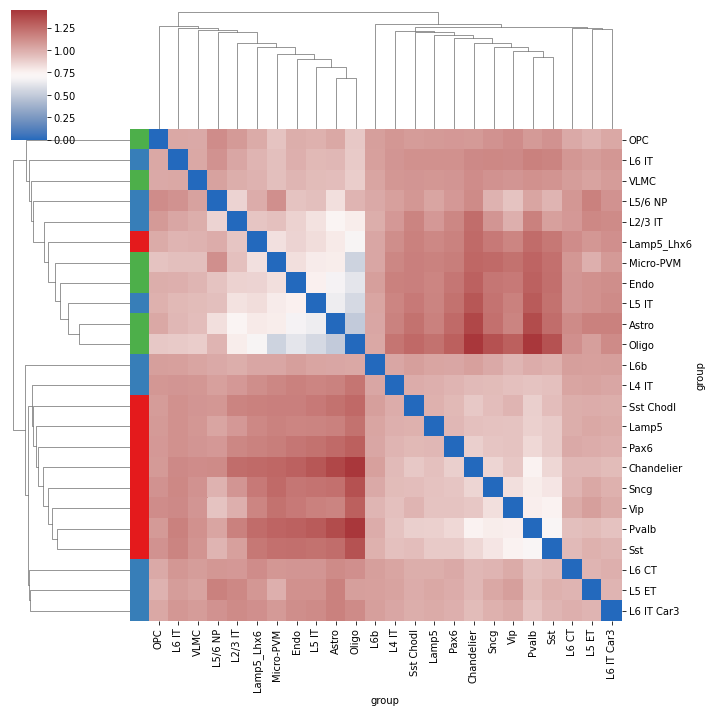

In [98]:
sns.clustermap(df_dist_df, row_linkage=linkage, col_linkage=linkage, cmap="vlag", row_colors=row_colors)

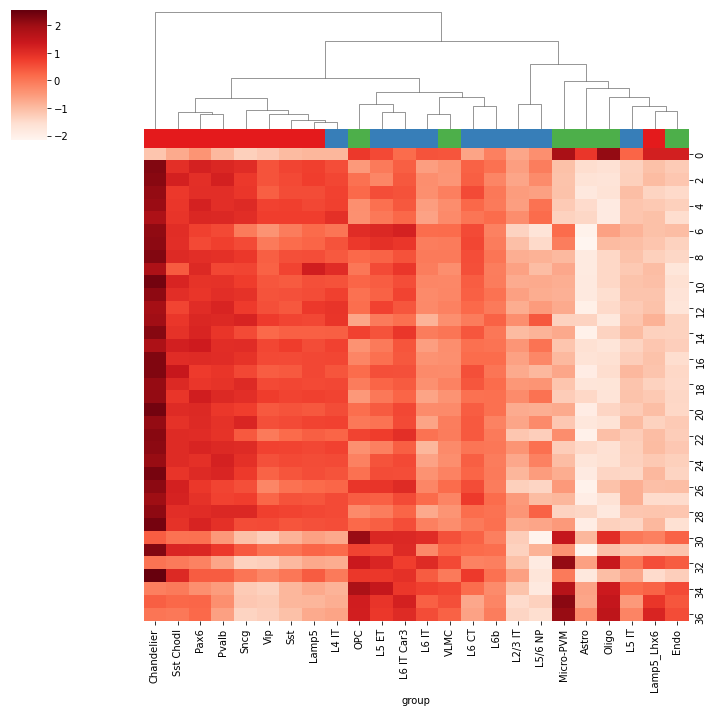

In [72]:

df_hba_modules = pd.read_csv(f'{base_folder}/hi_c_data_processing/data_human/{SRP_name}/{resolution}/cre_modules.bed', sep='\t', names=['c','d', 'e', 'f', 'ccre', 'chr', 'start', 'end', 'bin_id'])


df_hba_modules = df_hba_modules.drop_duplicates(['bin_id'], keep=False)
all_bins = []
mean_list = []
all_bins = []
for i in list(range(1,38)):
    m="M"+str(i)
    given_bins = df_hba_modules[df_hba_modules['ccre']==m]['bin_id'].tolist()
    all_bins.extend(given_bins)
    all_bins.extend(given_bins)
    mean_list.append(df_gene_tp_all_info_mean.loc[: , given_bins].mean(axis=1).values.tolist())
features_sc =  StandardScaler().fit_transform((np.vstack(mean_list)).T)
mean_list_df = pd.DataFrame(features_sc.T , columns = df_gene_tp_all_info_mean.index.get_level_values('group'))

sns.clustermap(mean_list_df, col_cluster=True, row_cluster=False, robust=False, z_score=0, col_colors=[row_colors], cmap='Reds')


(18, 18)
(18, 3)
0.6666666666666667
0.006172839506172867


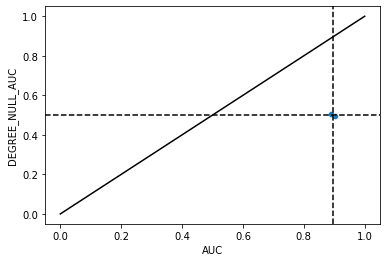

In [74]:
features = df_gene_tp_all_info_mean.loc[:, all_bins_std[all_bins_std >=0].index.tolist()]
features =features[0:18]
features_sc =  StandardScaler().fit_transform(features)
R1 = np.round(np.corrcoef(features_sc), 10)
R1 = R1 + abs(R1.min())
df_dist_df = pd.DataFrame(R1 ,  index=features .index.get_level_values('group'), columns = features .index.get_level_values('group'))


df_go = df_gene_tp_all_info_mean[[0]].reset_index()

df_go['val'] = 1

df_go_table = df_go.pivot_table(index='group', columns='classt', values='val', aggfunc='sum')
df_go_table.fillna(0, inplace=True)


df_2d_jac, go_chrom  = run_egad(df_go_table, df_dist_df )
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
sns.scatterplot(data=df_2d_jac, x='AUC', y='DEGREE_NULL_AUC')
plt.plot([0, 1], [0, 1], c='black')
plt.axvline(x=df_2d_jac['AUC'].mean(),c='black',ls='--')
plt.axhline(y=df_2d_jac['DEGREE_NULL_AUC'].mean(), c='black', ls='--')

In [70]:
df_2d_jac

AUC  AVG_NODE_DEGREE  DEGREE_NULL_AUC   P_Value
classt                                                             
GABAergic      0.888889        42.871384         0.444444  0.000165
Glutamatergic  0.392593        42.942661         0.525926  0.160653
Non-neuronal   0.962963        43.007426         0.537037  0.000138

In [68]:
df_2d_jac

AUC  AVG_NODE_DEGREE  DEGREE_NULL_AUC   P_Value
classt                                                             
GABAergic      0.925926        10.209226         0.385185  0.000042
Glutamatergic  0.392593        10.351934         0.466667  0.115658
Non-neuronal   0.916667        10.467739         0.685185  0.000532